# Predicting Fatal Shark Attacks in Hawaii Using Logistic Regression

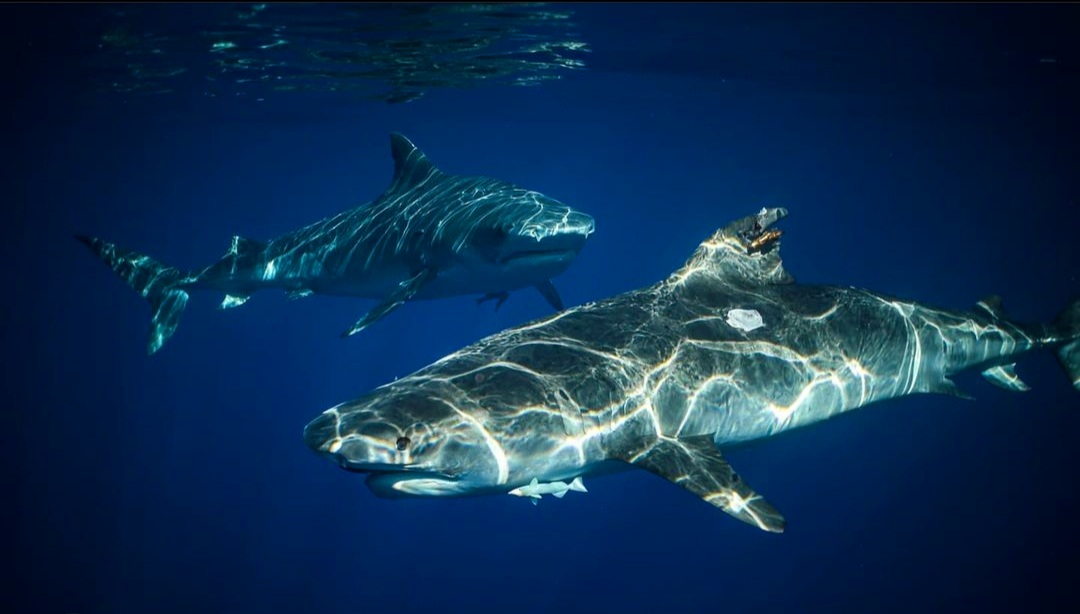

The image above was taken three miles off the north coast of Oahu, Hawaii. The creatures in the picture are Tiger sharks—massive, beautiful animals known for being among the most aggressive, or perhaps curious, sharks in the world. With over 140 recorded attacks and 39 fatalities globally, Tiger sharks are a frequent subject of concern for ocean enthusiasts. As a resident and waterman on the North Shore of Oahu, I’m well aware that shark attacks are one of the many risks we face each time we enter the water. In fact, experts say you’re 600 times more likely to drown in Hawaii due to the challenging water conditions than to be attacked by a shark.

However, most shark attacks are non-fatal. So, are there specific factors that determine whether an attack will result in a fatality? Does the water clarity, time of day, size of the shark, or the type of shark influence the outcome? These are the questions many of us surfers, swimmers, and ocean goers often think about when we’re in the water.

My goal is to predict whether an unprovoked shark attack in Hawaii will be fatal. Unprovoked attacks occur when a shark bites a person without any provocation. This project is designed to provide peace of mind for anyone who enjoys spending time in the water.

The most reliable data I found to answer these questions comes from [Hawaii.gov](https://dlnr.hawaii.gov/sharks/shark-incidents/incidents-list/). We’ll begin by scraping the data from this website and cleaning it to a suitable format for logistic regression modeling. Let’s dive in!

# Scraping Data and Converting to DataFrame

To scrape the data, we'll use the libraries requests and BeautifulSoup to extract all the rows and columns from the table on the website. Then we'll import pandas library and convert the data to a dataframe for easier handling.

In [1]:
# Importing libraries to scrape web
import requests
from bs4 import BeautifulSoup

# Sending request to url to retrieve data
url = 'https://dlnr.hawaii.gov/sharks/shark-incidents/incidents-list/'

try:
    response = requests.get(url)
    response.raise_for_status()

except requests.exceptions.HTTPError as e:
    print(f'HTTP Error: {e}')

In [2]:
# Transforming html on web page 
soup = BeautifulSoup(response.text, 'html.parser')

# Finding the table on the website
table = soup.find('table', {'id': 'tablepress-0'})

In [3]:
# The rows within the table
rows = table.find_all('tr')

# Creating a list of lists of all the information in the table to convert to dataframe
data = []
for row in rows:
    cols = row.find_all('td')
    cols = [col.text.strip() for col in cols]
    data.append(cols)

In [4]:
# Importing pandas libraries
import pandas as pd

# Column names for df
columns = ['Date and Time', 'Location', 'Activity', 'Water Clarity',
           'Water Depth', 'Victim', 'Description', 'Shark']

# Coverting 'data' with 'columns' to a pandas' dataframe
df = pd.DataFrame(data, columns=columns)

In [5]:
# Number of rows and columns respectively
print(df.shape)

# First five rows
df.head()

(166, 8)


,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark
0,None,None,None,None,None,None,None,None
1,"2024/06/23, before 12:20 pm","O‘ahu, Lā‘ie, Mālaekahana, distance from shore...",Surfing,Turbid,Unknown,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.
2,"2024/06/07, 1:40 pm","Oʻahu, Haleʻiwa, approx 3 miles from shore",Swimming with sharks,Clear,est 600 ft,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.
3,"2024/03/04, 4:55 pm","Oʻahu, Waikīkī, Old Mans, approx 350 yds from ...",Surfing,Turbid,10-15 ft,M. White,No injury; shark bit tail of surfboard.,"Tiger shark, length 8-10 feet"
4,"2024/03/02, 1:25 pm","Oʻahu, Ka‘a‘awa, Kualoa Beach, 5-10 feet from ...",Swimming,Turbid,est. 3 ft,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet"


There are `166` rows and `8` columns. It looks like we can create our target variable from the 'Description' column by seeing if the word 'Fatal' exists. It also looks like we'll be able to create a couple more columns based on the amount of information in each column. For instance we can create a column for month and time separately, and shark size column from the 'Shark' column. Let's start the cleaning process and see what we come up with.

# Data Cleaning

In [6]:
# Droping first useless row and resetting the index
df = df.drop([0]).reset_index(drop=True)

df.head()

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark
0,"2024/06/23, before 12:20 pm","O‘ahu, Lā‘ie, Mālaekahana, distance from shore...",Surfing,Turbid,Unknown,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.
1,"2024/06/07, 1:40 pm","Oʻahu, Haleʻiwa, approx 3 miles from shore",Swimming with sharks,Clear,est 600 ft,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.
2,"2024/03/04, 4:55 pm","Oʻahu, Waikīkī, Old Mans, approx 350 yds from ...",Surfing,Turbid,10-15 ft,M. White,No injury; shark bit tail of surfboard.,"Tiger shark, length 8-10 feet"
3,"2024/03/02, 1:25 pm","Oʻahu, Ka‘a‘awa, Kualoa Beach, 5-10 feet from ...",Swimming,Turbid,est. 3 ft,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet"
4,"2023/12/30, 11:10 am","Maui, Pāʻia Bay, approx 150 yds from shore",Surfing,Turbid,est 6-8 ft,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet"


In [7]:
# Info on columns before cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date and Time  165 non-null    object
 1   Location       165 non-null    object
 2   Activity       165 non-null    object
 3   Water Clarity  165 non-null    object
 4   Water Depth    165 non-null    object
 5   Victim         165 non-null    object
 6   Description    165 non-null    object
 7   Shark          165 non-null    object
dtypes: object(8)
memory usage: 10.4+ KB


## "Time" column

We'll create a new column by extracting the time from 'Date and Time' and convert to a 24-hour format. 

In [8]:
# Creates column 'Time' by extracting the time from 'Date and Time' using a regex pattern
df['Time'] = df['Date and Time'].str.extract(r'(\d+:\d+\s\w+?\.?\w+)')

# Increases the number of outputs we can see 
pd.set_option('display.max_rows', 500)

# Array of unique values in 'Time'
df['Time'].unique()

array(['12:20 pm', '1:40 pm', '4:55 pm', '1:25 pm', '11:10 am', '3:05 pm',
       '4:00 pm', '1:00 pm', '6:50 am', '12:30 pm', '11:55 pm',
       '11:30 am', '8:00 am', '12:00 pm', '11:00 am', '2:40 pm',
       '2:00 pm', '3:30 am', '6:00 pm', '10:30 am', '4:40 pm', '3:30 pm',
       '8:50 am', '4:30 pm', '7:20 am', '7:30 am', '7:55 am', '7:45 am',
       '2:55 pm', '8:25 am', '9:45 am', '10:00 am', '9:00 am', '10:10 am',
       '7:00 pm', '10:25 pm', '8:45 am', '8:30 am', '1:00 am', '1:30 pm',
       '9:30 am', '2:15 pm', '2:10 pm', '5:45 pm', '9:15 am', '4:50 pm',
       '9:50 am', '2:25 pm', '5:35 am', '3:50 pm', '2:50 p.m', '11:20 am',
       '10:20 am', '11:15 am', '5:20 pm', '3:20 pm', '3:55 pm', '8:15 am',
       '12:50 pm', '8:20 am', '1:20 pm', '9:40 am', '3:45 pm', '4:35 pm',
       '11:05 am', '1:15 pm', '1:50 pm', '6:00 am', '8:03 pm', '3:00 pm',
       '7:05 am', '2:30 pm', '7:13 am', '12:55 pm', '12:45 pm',
       '10:45 am', '3:35 pm', '7:50 am', '1:45 pm', '12:00 noon',

In [9]:
# Replacing string characters and removing extra whitespace as to convert to datetime next
df['Time'] = df['Time'].str.replace('.', '', regex=False)
df['Time'] = df['Time'].str.replace('noon', 'pm', regex=False)
df['Time'] = df['Time'].str.strip()

# Number of rows to check we still have all 165 values
print(f"Number of rows in 'Time': {df['Time'].shape[0]}")

# Array of unique values in 'Time'
df['Time'].unique()

Number of rows in 'Time': 165


array(['12:20 pm', '1:40 pm', '4:55 pm', '1:25 pm', '11:10 am', '3:05 pm',
       '4:00 pm', '1:00 pm', '6:50 am', '12:30 pm', '11:55 pm',
       '11:30 am', '8:00 am', '12:00 pm', '11:00 am', '2:40 pm',
       '2:00 pm', '3:30 am', '6:00 pm', '10:30 am', '4:40 pm', '3:30 pm',
       '8:50 am', '4:30 pm', '7:20 am', '7:30 am', '7:55 am', '7:45 am',
       '2:55 pm', '8:25 am', '9:45 am', '10:00 am', '9:00 am', '10:10 am',
       '7:00 pm', '10:25 pm', '8:45 am', '8:30 am', '1:00 am', '1:30 pm',
       '9:30 am', '2:15 pm', '2:10 pm', '5:45 pm', '9:15 am', '4:50 pm',
       '9:50 am', '2:25 pm', '5:35 am', '3:50 pm', '2:50 pm', '11:20 am',
       '10:20 am', '11:15 am', '5:20 pm', '3:20 pm', '3:55 pm', '8:15 am',
       '12:50 pm', '8:20 am', '1:20 pm', '9:40 am', '3:45 pm', '4:35 pm',
       '11:05 am', '1:15 pm', '1:50 pm', '6:00 am', '8:03 pm', '3:00 pm',
       '7:05 am', '2:30 pm', '7:13 am', '12:55 pm', '12:45 pm',
       '10:45 am', '3:35 pm', '7:50 am', '1:45 pm', '5:00 pm', '7:

In [10]:
# Import datetime to parse time
from datetime import datetime
 
# Parse the time string into a datetime object and format to 24-hour returning only the hour
def convert_24(time):
    t = datetime.strptime(time, '%I:%M %p')

    return t.strftime('%H')

# Applying function to every value in column
df['Time'] = df['Time'].apply(convert_24)

# Distribution of values in ascending order by time
df['Time'].value_counts().sort_index()

01     1
03     3
05     1
06     2
07    12
08    19
09     7
10    18
11    19
12    10
13    15
14    11
15    15
16    18
17     4
18     5
19     1
20     1
22     1
23     2
Name: Time, dtype: int64

We'll left with the hour of the day to represent in the 'Time' column. Using only the hour will help our model generalize better by condensing all the times into smaller groups.

## 'Date and Time' to 'Month' Column

Extracting only the month from 'Date and Time' makes more sense for the kind of problem we'll trying to handle. Sharks as I know tend to be more active during certain months, not on certain days. This will also help simplify the model for generalization.

In [11]:
# Creates column 'Month' by extracting the month from 'Date and Time' using a regex pattern
df['Month'] = df['Date and Time'].str.extract(r'/(\d+)/')

# Number of rows to check we still have all 165 values
print(f"Number of rows in 'Month': {df['Month'].shape[0]}")

# Distribution of values in ascending order by month
df['Month'].value_counts().sort_index()

Number of rows in 'Month': 165


01    10
02     8
03    16
04    12
05    12
06    11
07     8
08    11
09    15
10    32
11    14
12    16
Name: Month, dtype: int64

Most of the attacks happen in October. This is why they call it shark-tober here in Hawaii!

## Creating 'Moon Phase' Column 

Another column we can create from 'Date and Time' is the moon phase for each instance. Science has shown that phases of the moon affect marine life in numerous ways, including reproduction, feeding patterns, migration, and predator-prey interactions. I'd be curious to see if there are any patterns connecting certain moon phases to fatal shark attacks.

I found this [moon phase algorithm](https://stackoverflow.com/questions/2526815/moon-lunar-phase-algorithm) off a Stack Overflow entry from [Richard](https://stackoverflow.com/users/752843/richard) which is based off the PyEphem astronomy library. The function takes in a year, month, and day from a specific date and returns the corresponding moon phase as floating points. The phases go as `0 = new moon, 0.5 = full moon, 1 = new moon` again; it completes its cycle then restarts. 

We'll create a moon phase column by extracting the date from 'Date and Time', converting to datetime object, applying the moon phase function to each row and appending the values to a list, and then converting the list back to a series in our dataframe. Let's get started.

In [12]:
# Keeping only the date from 'Date and Time'
df['Date and Time'] = df['Date and Time'].str.extract(r'(\d+/\d+/\d+)')

df.head()

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month
0,2024/06/23,"O‘ahu, Lā‘ie, Mālaekahana, distance from shore...",Surfing,Turbid,Unknown,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.,12,06
1,2024/06/07,"Oʻahu, Haleʻiwa, approx 3 miles from shore",Swimming with sharks,Clear,est 600 ft,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.,13,06
2,2024/03/04,"Oʻahu, Waikīkī, Old Mans, approx 350 yds from ...",Surfing,Turbid,10-15 ft,M. White,No injury; shark bit tail of surfboard.,"Tiger shark, length 8-10 feet",16,03
3,2024/03/02,"Oʻahu, Ka‘a‘awa, Kualoa Beach, 5-10 feet from ...",Swimming,Turbid,est. 3 ft,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,03
4,2023/12/30,"Maui, Pāʻia Bay, approx 150 yds from shore",Surfing,Turbid,est 6-8 ft,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet",11,12


In [13]:
# Import ephem to help calculate moon phase
import ephem
import datetime

# Returns a floating-point number from 0-1. where 0=new, 0.5=full, 1=new
def get_phase_on_day(year: int, month: int, day: int):
    
    # Ephem stores its date numbers as floating points, which the following uses
    # to conveniently extract the percent time between one new moon and the next.
    # This corresponds (somewhat roughly) to the phase of the moon.

    # Use Year, Month, Day as arguments
    date = ephem.Date(datetime.date(year,month,day))

    # Next and previous new moon 
    nnm = ephem.next_new_moon(date)
    pnm = ephem.previous_new_moon(date)

    # Lunation calculation
    lunation = (date - pnm) / (nnm - pnm)

    return lunation

In [14]:
# Converting to datetime to easily grab values below
df['Date and Time'] = pd.to_datetime(df['Date and Time'])

# Using 'get_phase_on_day' function by looping thru 'Date and Time' and grabbing the individual values needed,
# then appending rounded values to 'phases' list to later convert to a series
phases = []
for value in df['Date and Time']:
    year = int(value.year)
    month = int(value.month)
    day = int(value.day)
    phases.append(round(get_phase_on_day(year, month, day), 2)) 
    
# Creating new column 'Moon Phase' using 'phases' list
df['Moon Phase'] = pd.Series(phases)

df.head()

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase
0,2024-06-23,"O‘ahu, Lā‘ie, Mālaekahana, distance from shore...",Surfing,Turbid,Unknown,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.,12,06,0.56
1,2024-06-07,"Oʻahu, Haleʻiwa, approx 3 miles from shore",Swimming with sharks,Clear,est 600 ft,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.,13,06,0.02
2,2024-03-04,"Oʻahu, Waikīkī, Old Mans, approx 350 yds from ...",Surfing,Turbid,10-15 ft,M. White,No injury; shark bit tail of surfboard.,"Tiger shark, length 8-10 feet",16,03,0.78
3,2024-03-02,"Oʻahu, Ka‘a‘awa, Kualoa Beach, 5-10 feet from ...",Swimming,Turbid,est. 3 ft,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,03,0.72
4,2023-12-30,"Maui, Pāʻia Bay, approx 150 yds from shore",Surfing,Turbid,est 6-8 ft,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet",11,12,0.58


From our snippet of the dataframe, looks like we have a 'Moon Phase' column with the corresponding moon phases for each instance.

## 'Location' Column

In [15]:
# Looking at distribution of 'Location'
df['Location'].value_counts()

Oʻahu, Haleʻiwa, approx 3 miles from shore                                         5
O‘ahu, Kaiwi Channel, approx 12 miles east-southeast of Koko Head                  2
Hawai‘i, Kailua-Kona, Lyman Beach; approx 10 yards from shore                      2
Hawai‘i, Kailua-Kona, Keahole Point, approx 1 mile from shore                      2
Maui, Honokōwai; 100 yds from shore                                                2
Hawai‘i, approx 10 miles northwest of ‘Upolu Pt                                    1
Maui, Kahului Harbor, Trenches; approx 300 yds from shore                          1
Maui, Pā‘ia, Mantokuji Bay; approx 75 yds from shore                               1
Kaua‘i, Hanalei Bay; approx 400 yds from shore                                     1
Maui, Kīhei, Kalama; approx 300 yds from shore                                     1
Hawai‘i, Ka‘ū, Kāwā; approx 50 yds from shore                                      1
Maui, Kā‘anapali, Honokōwai; approx 10 yds from shore            

There's a lot going on in this column. Let's start by extracting the island and the city/beach from each row.

In [16]:
# Split each row on the comma to grab island and city/beach names
df['Location'] = df['Location'].str.split(',')

# Viewing distributions and our split 
df['Location'].value_counts()

[Oʻahu,  Haleʻiwa,  approx 3 miles from shore]                                         5
[O‘ahu,  Kaiwi Channel,  approx 12 miles east-southeast of Koko Head]                  2
[Hawai‘i,  Kailua-Kona,  Lyman Beach; approx 10 yards from shore]                      2
[Hawai‘i,  Kailua-Kona,  Keahole Point,  approx 1 mile from shore]                     2
[Maui,  Honokōwai; 100 yds from shore]                                                 2
[Hawai‘i,  approx 10 miles northwest of ‘Upolu Pt]                                     1
[Maui,  Kahului Harbor,  Trenches; approx 300 yds from shore]                          1
[Maui,  Pā‘ia,  Mantokuji Bay; approx 75 yds from shore]                               1
[Kaua‘i,  Hanalei Bay; approx 400 yds from shore]                                      1
[Maui,  Kīhei,  Kalama; approx 300 yds from shore]                                     1
[Hawai‘i,  Ka‘ū,  Kāwā; approx 50 yds from shore]                                      1
[Maui,  Kā‘anapali,  

In [17]:
# List of formatted locations
locations = []

# Looping thru 'Location' to grab island and beach names and appending to list to later assign back to 'Location'
for row in df['Location']:
    
    # First item in the list of each row 
    island = row[0]
    
    # Second item in the list of each row
    beach = row[1]
    
    # Some beaches needed to be split again but by semi-colon this time
    beach = beach.split(';')[0]
    
    # Formatting island and beach and appending to list 'locations'
    location = f'{island},{beach}'
    locations.append(location.strip())


# Convert list to series and assigning back to 'Location' in df
df['Location'] = pd.Series(locations)

# New distribution counts of 'Location'
df['Location'].value_counts()

Maui, Kīhei                                        15
Hawai‘i, Kailua-Kona                                7
Oʻahu, Haleʻiwa                                     6
O‘ahu, Kawailoa                                     5
Hawai‘i, ‘Anaeho‘omalu                              4
Kaua‘i, Kekaha                                      4
Maui, Pā‘ia                                         4
Maui, Kā‘anapali                                    4
Kaua‘i, Hanalei Bay                                 4
O‘ahu, Kaiwi Channel                                3
O‘ahu, Kalaeloa                                     3
Maui, Honokōwai                                     3
O‘ahu, Ka‘a‘awa                                     3
O‘ahu, Makaha Beach                                 3
Maui, Mākena                                        3
Maui, Olowalu                                       3
Maui, Wailea                                        3
O‘ahu, Sunset Beach                                 2
Kaua‘i, Po‘ipū              

Since there are a lot of different locations, we'll go ahead and keep only the islands. This will help the model generalize better.

In [18]:
# Splitting island and beach in each row and appending only island to list to later create new column 'Island'
islands = []
for row in df['Location'].str.split(','):
    island = row[0]
    islands.append(island)

# Creating new column 'Island'
df['Island'] = pd.Series(islands)

# Distribution of 'Island' column
df['Island'].value_counts()

Maui        65
O‘ahu       34
Hawai‘i     31
Kaua‘i      22
Oʻahu        8
Lāna‘i       3
Moloka‘i     2
Name: Island, dtype: int64

In [19]:
# Checking unique values of 'Island' by checking spelling and spaces
df['Island'].unique()

array(['O‘ahu', 'Oʻahu', 'Maui', 'Kaua‘i', 'Hawai‘i', 'Moloka‘i',
       'Lāna‘i'], dtype=object)

There seems to be two islands with the name `Oʻahu` which would be new to me! I can't seem to find out why our output has both because from the naked eye, they look the same. Maybe the 'okina (a pause in speech in polynesian languages; looks like an apostrophe) could be typed in differently. Either way, we will remove the 'okina and see if that works.

In [20]:
# Dictionary for new spellings of island names by removing the 'okina
island_mapping = {'O‘ahu': 'Oahu', 
                  'Oʻahu': 'Oahu', 
                  'Maui': 'Maui', 
                  'Kaua‘i': 'Kauai',
                  'Hawai‘i': 'Hawaii', 
                  'Moloka‘i': 'Molokai', 
                  'Lāna‘i': 'Lanai'}

# Applying mapping to 'Island' 
df['Island'] = df['Island'].replace(island_mapping)

# New Distribution of 'Island' column
df['Island'].value_counts()

Maui       65
Oahu       42
Hawaii     31
Kauai      22
Lanai       3
Molokai     2
Name: Island, dtype: int64

That seemed to do the job. `Maui` has the most attacks.

In [21]:
# A look at df so far
df.head()

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
0,2024-06-23,"O‘ahu, Lā‘ie",Surfing,Turbid,Unknown,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.,12,06,0.56,Oahu
1,2024-06-07,"Oʻahu, Haleʻiwa",Swimming with sharks,Clear,est 600 ft,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.,13,06,0.02,Oahu
2,2024-03-04,"Oʻahu, Waikīkī",Surfing,Turbid,10-15 ft,M. White,No injury; shark bit tail of surfboard.,"Tiger shark, length 8-10 feet",16,03,0.78,Oahu
3,2024-03-02,"Oʻahu, Ka‘a‘awa",Swimming,Turbid,est. 3 ft,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,03,0.72,Oahu
4,2023-12-30,"Maui, Pāʻia Bay",Surfing,Turbid,est 6-8 ft,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet",11,12,0.58,Maui


## 'Activity' Column

In [22]:
# Distribution of 'Activity' column
df['Activity'].value_counts()

Surfing                    60
Swimming                   31
Snorkeling                 21
Stand-up paddleboarding    13
Body boarding               9
Spearfishing                9
Swimming with sharks        5
Wading                      3
Treading water              2
Surfing - kite              2
Floating                    2
SCUBA diving                2
Paddling                    1
Standing                    1
Fishing                     1
Fishing from kayak          1
Fishing from surfboard      1
Surfing - wind              1
Name: Activity, dtype: int64

The activity `Surfing` has the most attacks. Let's investigate some rows and see if we can condense some activities for better model generalization.

In [23]:
# Rows of Activity when equal to 'Standing'
df[df['Activity'] == 'Standing'] # on-shore

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
74,2015-03-18,"Hawai‘i, South Kohala",Standing,Turbid,4-5 feet,K. Grasing,Extensive laceration to left forearm; lacerati...,"Tiger shark, length estimated at 8-10 feet.",11,03,0.92,Hawaii


In [24]:
# Rows of Activity when equal to 'Wading'
df[df['Activity'] == 'Wading'] # on-shore

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
117,2008-07-26,"Maui, Kā‘anapali",Wading,Turbid,est 3 ft,U. Mataafa,Lacerations to left calf. Not confirmed as sha...,Data insufficient.,15,07,0.78,Maui
129,2006-02-27,"Maui, Mākena",Wading,Turbid,2-3 ft,N. Raleigh,Multiple wounds to right leg.,"Requiem shark, length 8 feet.",16,02,0.97,Maui
139,2003-10-05,"Maui, Kīhei",Wading,Turbid,4-5 ft,C. Alo,"Bitten on left thigh, right knee, and right in...","Species unknown, length 4-5 feet.",12,10,0.30,Maui


We can condense these rows under the category 'Onshore', meaning an onshore or close to onshore activity like standing or wading.

In [25]:
# Rows of Activity when equal to 'Fishing'
df[df['Activity'] == 'Fishing'] # fishing, provoked

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
75,2015-01-27,"Maui, Pali scenic lookout",Fishing,Turbid,on shore,M. Pollard,Lacerations to left calf. Considered a provoke...,"Requiem shark, length 4 feet.",03,01,0.22,Maui


You can read [here](https://www.hawaiinewsnow.com/story/27963075/maui-fisherman-stitched-up-after-shark-bite/) that on this shark attack instance, M.Pollard was fishing and caught the shark on shore and then was trying to push the shark back into the water when the shark started flailing and snagged his leg. This intance is an anomaly to our data and would be an outlier if we kept 'on shore' under the 'Water Depth' column given sharks aren't known to be roaming on land. It's also considered a provoked attack. We'll go ahead and remove this row. 

In [26]:
# Dropping row 75 where column 'Activity' equals 'Fishing'
df = df.drop(75, axis=0)

In [27]:
# Rows of Activity when equal to 'Floating'
df[df['Activity'] == 'Floating'] # Change to Swimming

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
19,2022-02-09,"Hawai‘i, Kailua-Kona",Floating,Clear,est 1200 ft,Confidential,Bitten on right foot and calf.,"Cookiecutter shark, length unknown",03,02,0.26,Hawaii
62,2016-05-03,"Maui, Wailea Beach",Floating,Turbid,15-20 ft,Confidential,Minor lacerations to right shoulder.,Species and length unknown.,15,05,0.87,Maui


In [28]:
# Rows of Activity when equal to 'Paddling'
df[df['Activity'] == 'Paddling'] # Paddling

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
44,2019-04-23,"Hawai‘i, ‘Anaeho‘omalu",Paddling,Clear,est 30 ft,K. Bishop,"Severe lacerations to inner right thigh, lacer...","Requiem shark, length 6-8 feet.",08,04,0.6,Hawaii


In [29]:
# Rows of Activity when equal to 'Treading water'
df[df['Activity'] == 'Treading water'] # Change to Swimming

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
39,2019-08-20,"Hawai‘i, Kealakekua Bay",Treading water,Turbid,10-15 feet,Confidential,Bitten on back of lower torso.,Species and length unknown.,08,08,0.64,Hawaii
56,2016-11-14,"Maui, Kīhei",Treading water,Clear,est 15 ft,B. Zawacki,Multiple lacerations to right leg.,Species and length unknown.,10,11,0.48,Maui


In [30]:
# Rows of Activity when equal to 'SCUBA diving'
df[df['Activity'] == 'SCUBA diving'] # Change to Scuba

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
16,2022-09-09,"Hawai‘i, Kailua-Kona",SCUBA diving,Clear,200-250 ft,Confidential,Lacerations and puncture wounds on left calf a...,"Blacktip shark, length 7-8 feet",14,09,0.43,Hawaii
18,2022-03-21,"Hawai‘i, Kailua-Kona",SCUBA diving,Clear,est 200 ft,Confidential,Puncture wound on right big toe. Considered a ...,"Galapagos shark, length 6 feet",14,03,0.62,Hawaii


We'll simplify and consolidate a few categories below.

In [31]:
# Consolidating some categories in 'Activity' using this mapping
activity_mapping = {'Standing': 'Onshore',
                    'Wading': 'Onshore',
                    'Floating': 'Swimming',
                    'Treading water': 'Swimming',
                    'Fishing from kayak': 'Fishing',
                    'Fishing from surfboard': 'Fishing',
                    'Surfing - wind': 'Surfing',
                    'Surfing - kite': 'Surfing'}

# Applying mapping to 'Activity'
df['Activity'] = df['Activity'].replace(activity_mapping)

# New distribution counts of 'Activity'
df['Activity'].value_counts()

Surfing                    63
Swimming                   35
Snorkeling                 21
Stand-up paddleboarding    13
Spearfishing                9
Body boarding               9
Swimming with sharks        5
Onshore                     4
SCUBA diving                2
Fishing                     2
Paddling                    1
Name: Activity, dtype: int64

## 'Water Clarity' Column

In [32]:
# Distribution of 'Water Clarity' column
df['Water Clarity'].value_counts()

Turbid     85
Clear      68
Unknown     7
Muddy       3
            1
Name: Water Clarity, dtype: int64

In [33]:
# Checking spelling and spacing of unique values in 'Water Clarity'
df['Water Clarity'].unique()

array(['Turbid', 'Clear', 'Unknown', 'Muddy', ''], dtype=object)

In [34]:
# Rows where 'Water Clarity' equals 'Unknown'
df[df['Water Clarity'] == 'Unknown']

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
59,2016-09-07,"O‘ahu, Mākaha Beach",Swimming,Unknown,25-30 ft,Confidential,"Lacerations to right shoulder, upper back, and...",Species and length unknown.,14,09,0.19,Oahu
96,2012-12-05,"Kaua‘i, Pākalā",Surfing,Unknown,Unknown,Confidential,Injuries to left foot.,"Species unknown, length 10 feet.",13,12,0.72,Kauai
141,2003-05-10,"Hawai‘i, Kahalu‘u",Swimming,Unknown,8 ft,K. Paulo,"Bitten on right lower calf, ankle, and foot.","Requiem shark, length 6-7 feet.",12,05,0.29,Hawaii
147,2002-06-11,"Kaua‘i, ‘Anini Beach",Surfing,Unknown,Unknown,C. Levin,No injury. Shark came from behind and bit side...,"Tiger shark, length 8-9 feet.",13,06,0.00,Kauai
157,1999-08-09,"O‘ahu, Mokulua Island",Swimming,Unknown,Unknown,S. Watkins,Minor injury to right foot.,"Requiem shark, length unknown.",13,08,0.92,Oahu
161,1997-06-25,"O‘ahu, Sunset Beach",Spearfishing,Unknown,Unknown,Confidential,Bitten on left leg just above ankle while nigh...,"Species unknown, length 8 feet.",23,06,0.67,Oahu
162,1996-08-29,"Maui, Paukūkalo",Body boarding,Unknown,Unknown,D. Nanod,Bitten on right calf; shark approached from be...,"Tiger shark, length 8 feet.",16,08,0.50,Maui


In [35]:
# Rows where 'Water Clarity' equals ''
df[df['Water Clarity'] == '']

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island
152,2001-03-23,"O‘ahu, Sandy Beach",Body boarding,,6-8 ft,M. Mendez,Bitten on left hand. Portion of body board's l...,"Requiem shark, length 3-5 feet.",14,03,0.93,Oahu


Being a surfer and a free diver myself, water clarity can change from clear to turbid and vice versa daily at the same beaches depending on a bunch of factors such as wind, swell, ect. So the best way to deal with these missing values is to replace them with the mode.

In [36]:
# Replacing missing values with the mode 
df['Water Clarity'] = df['Water Clarity'].replace('', 'Turbid', regex=False)
df['Water Clarity'] = df['Water Clarity'].str.replace('Unknown', 'Turbid', regex=False)

# Checking for value changes
df['Water Clarity'].value_counts()

Turbid    93
Clear     68
Muddy      3
Name: Water Clarity, dtype: int64

`Turbid` water has the most attacks. This is understandable, as I've always heard that sharks are more likely to attack in low light or turbid water due to their limited eyesight, which makes it difficult for them to distinguish humans from their usual prey. We'll see later if tubid water is associated with fatal attacks.

## 'Water Depth' Column

In [37]:
# Distribution of 'Water Depth' column
df['Water Depth'].value_counts()

est 10 ft                                        13
est 6 ft                                         10
Unknown                                           9
10-15 ft                                          7
15-20 ft                                          5
est 20 ft                                         5
est 600 ft                                        5
over 2,000 ft                                     4
est 25 ft                                         4
20 ft                                             4
est 8 ft                                          4
est 12 ft                                         3
5-8 ft                                            3
est 10-15 ft                                      3
est 60 ft                                         3
6-8 ft                                            3
est 30 ft                                         3
25-30 ft                                          3
10 ft                                             2
5-10 ft     

We'll go ahead and extract the first number in the range of each row and convert to a numerical dtype.

In [38]:
# Removing commas in numbers
df['Water Depth'] = df['Water Depth'].str.replace(',', '', regex=False)

# Extracting the first numbers in each row
df['Water Depth'] = df['Water Depth'].str.extract(r'(\d+)')

# Converting to float so to order the index in value_counts
df['Water Depth'] = df['Water Depth'].astype(float)

In [39]:
# New distribution of 'Water Depth' with the amount of feet in ascending order
df['Water Depth'].value_counts(dropna=False).sort_index()

2.0        2
3.0        4
4.0        8
5.0       10
6.0       25
7.0        3
8.0       10
10.0      29
12.0       5
15.0       9
20.0      11
25.0       9
30.0       4
35.0       2
40.0       2
50.0       1
60.0       3
70.0       1
75.0       1
100.0      1
200.0      3
600.0      5
1200.0     1
1800.0     1
2000.0     4
NaN       10
Name: Water Depth, dtype: int64

For now we will replace the `NaN` values with the mode to finish cleaning this column.

In [40]:
# Import numpy library to represent nan values
import numpy as np

# Mode of 'Water Depth'
water_depth_mode = int(df['Water Depth'].mode())

# Replacing nan with the mode of 'Water Depth'
df['Water Depth'].replace(np.nan, water_depth_mode, inplace=True)

# Converting to int dtype
df['Water Depth'] = df['Water Depth'].astype(int)

In [41]:
# Checking work to see if nans are still there
df['Water Depth'].value_counts(dropna=False).sort_index()

2        2
3        4
4        8
5       10
6       25
7        3
8       10
10      39
12       5
15       9
20      11
25       9
30       4
35       2
40       2
50       1
60       3
70       1
75       1
100      1
200      3
600      5
1200     1
1800     1
2000     4
Name: Water Depth, dtype: int64

Most of the attackes happen in shallower water under the 20-25ft ranges. We may use binning on this column later given the wide distribution of values.

## 'Description' Column

This column is where we will create our target variable from for our model.

In [42]:
# Looking through rows to see how to capture 'Fatal' for our classification variable
df['Description']

0      Fatal; loss of right forearm, severe laceratio...
1      Lacerations to right thigh, forearm, and hand....
2                No injury; shark bit tail of surfboard.
3                              Lacerations to left foot.
4                               Fatal; loss of left leg.
5                           Laceractions to right thigh.
6      Deep lacerations and puncture wounds to left leg.
7                 No injury; shark bit tail of surfboard
8      Severe injuries to lower right leg resulting i...
9      Lacerations to back of left knee and left hand...
10     Semi-circular puncture wounds to chest and abd...
11           No injury; shark bit back of inflatable SUP
12      Lacerations to lower left torso and right thumb.
13                          Fatal; victim not recovered.
14            No injury; shark bit off part of swim fin.
15                          Laceration to right big toe.
16     Lacerations and puncture wounds on left calf a...
17     Loss of left arm below s

In [43]:
# Function that returns a 1 if 'Fatal' is in the row, if not returns a 0, for a new column
df['Fatal'] = df['Description'].apply(lambda x: 1 if 'Fatal' in x else 0)

# Distribution of new column
df['Fatal'].value_counts()

0    155
1      9
Name: Fatal, dtype: int64

The majority class is negative (0) and the minority is positive (1). The data is pretty unbalanced.

In [44]:
df.head()

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island,Fatal
0,2024-06-23,"O‘ahu, Lā‘ie",Surfing,Turbid,10,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.,12,06,0.56,Oahu,1
1,2024-06-07,"Oʻahu, Haleʻiwa",Swimming with sharks,Clear,600,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.,13,06,0.02,Oahu,0
2,2024-03-04,"Oʻahu, Waikīkī",Surfing,Turbid,10,M. White,No injury; shark bit tail of surfboard.,"Tiger shark, length 8-10 feet",16,03,0.78,Oahu,0
3,2024-03-02,"Oʻahu, Ka‘a‘awa",Swimming,Turbid,3,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,03,0.72,Oahu,0
4,2023-12-30,"Maui, Pāʻia Bay",Surfing,Turbid,6,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet",11,12,0.58,Maui,1


## 'Shark' Column

## Pt. 1

In [45]:
# Distribution of 'Shark' column
df['Shark'].value_counts()

Species and length unknown.                        27
Tiger shark, length 10-12 feet.                    10
Tiger shark, length 8-10 feet.                      9
Tiger shark, length 10 feet.                        7
Tiger shark, length 8 feet.                         6
Tiger shark, length 12 feet.                        6
Tiger shark, length uncertain.                      4
Tiger shark, length estimated at 10 feet.           4
Species unknown, length 10 feet.                    4
Tiger shark, length 8-10 feet                       4
Species unknown, length 6-8 feet.                   4
Tiger shark, length unknown.                        3
Species and length unknown                          3
Tiger shark, length estimated at 12 feet.           3
Cookiecutter shark, length unknown.                 3
Requiem shark, small.                               3
Requiem shark, length unknown.                      2
Galapagos shark, length 5-9 feet.                   2
Tiger shark, length estimate

Let's get a count of each species of shark before extracting each shark type into a new column.

In [46]:
# Using str.contains regex pattern to group together and get a sum of the same type of sharks 
# so we know how many we need when we extract these sharks for a new column

tiger = df['Shark'].str.contains('Tiger shark', regex=True).sum()

requiem = df['Shark'].str.contains('Requiem shark', regex=True).sum()

unknown_species = df['Shark'].str.contains('Species', regex=True).sum()

cookie = df['Shark'].str.contains('Cookiecutter', regex=True).sum()

galapagos = df['Shark'].str.contains('Galapagos', regex=True).sum()

insufficient = df['Shark'].str.contains('insufficient', regex=True).sum()

whitetip = df['Shark'].str.contains('Whitetip', regex=True).sum()

gray = df['Shark'].str.contains('Gray', regex=True).sum()

blacktip = df['Shark'].str.contains('Blacktip', regex=True).sum()

great_white = df['Shark'].str.contains('White shark', regex=True).sum()

# Pretty printing each shark and their frequency
print(f'''Amount of Shark Attacks per Species:

Tiger Shark: {tiger}
Requiem Shark: {requiem}
Cookiecutter: {cookie}
Galapagos Shark: {galapagos}
Whitetip Reef Shark: {whitetip}
Blacktip Reef Shark: {blacktip}
Gray Shark: {gray}
Great White Shark: {great_white}
Species Unknown: {unknown_species + insufficient}

Total Shark Attacks: {tiger + requiem + cookie + galapagos + whitetip + blacktip + gray + great_white + unknown_species + insufficient}''')

Amount of Shark Attacks per Species:

Tiger Shark: 77
Requiem Shark: 16
Cookiecutter: 6
Galapagos Shark: 5
Whitetip Reef Shark: 2
Blacktip Reef Shark: 2
Gray Shark: 1
Great White Shark: 1
Species Unknown: 54

Total Shark Attacks: 164


Tiger sharks claim the most attacks with 77 while 54 of species are unknown.

In [47]:
# Extracting Shark types from 'Shark' using regex pattern into new column
df['Shark Type'] = df['Shark'].str.extract('(Tiger|Requiem|Species|Cookiecutter|Galapagos|insufficient|Whitetip|Blacktip|Gray|White)')

In [48]:
# Distribution of 'Shark Type' column
df['Shark Type'].value_counts()

Tiger           77
Species         52
Requiem         16
Cookiecutter     6
Galapagos        5
Blacktip         2
Whitetip         2
insufficient     2
White            1
Gray             1
Name: Shark Type, dtype: int64

In [49]:
# Seeing if 'Shark Type' matches up with 'Shark'
df

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island,Fatal,Shark Type
0,2024-06-23,"O‘ahu, Lā‘ie",Surfing,Turbid,10,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.,12,06,0.56,Oahu,1,Species
1,2024-06-07,"Oʻahu, Haleʻiwa",Swimming with sharks,Clear,600,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.,13,06,0.02,Oahu,0,Species
2,2024-03-04,"Oʻahu, Waikīkī",Surfing,Turbid,10,M. White,No injury; shark bit tail of surfboard.,"Tiger shark, length 8-10 feet",16,03,0.78,Oahu,0,Tiger
3,2024-03-02,"Oʻahu, Ka‘a‘awa",Swimming,Turbid,3,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,03,0.72,Oahu,0,Species
4,2023-12-30,"Maui, Pāʻia Bay",Surfing,Turbid,6,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet",11,12,0.58,Maui,1,Species
5,2023-10-25,"Oʻahu, Haleʻiwa",Surfing,Turbid,4,Confidential,Laceractions to right thigh.,"Tiger shark, length estimated at 8 feet",15,10,0.35,Oahu,0,Tiger
6,2023-10-15,"Kaua‘i, Hanalei Bay",Surfing,Turbid,20,K. Kanehe,Deep lacerations and puncture wounds to left leg.,"Tiger shark, length estimated at 10 feet",16,10,0.01,Kauai,0,Tiger
7,2023-10-02,"Maui, Ku‘au Bay",Surfing,Turbid,5,K. Cole,No injury; shark bit tail of surfboard,"Galapagos shark, length 10-12 feet",13,10,0.57,Maui,0,Galapagos
8,2023-04-09,"O‘ahu, Kewalo",Surfing,Clear,4,M. Morita,Severe injuries to lower right leg resulting i...,"Tiger shark, length 8-10 feet",06,04,0.62,Oahu,0,Tiger
9,2023-03-19,"Hawai‘i, ‘Anaeho‘omalu",Swimming,Turbid,10,L. Livingston,Lacerations to back of left knee and left hand...,"Blacktip reef sharks, length 5 ft",12,03,0.91,Hawaii,0,Blacktip


In [50]:
# New mapping to rename shark types in column
shark_type_mapping = {'Tiger': 'Tiger shark',
                  'Species': 'Species unknown',
                  'Requiem': 'Requiem shark',
                  'Cookiecutter': 'Cookiecutter shark',
                  'Galapagos': 'Galapagos shark',
                  'Blacktip': 'Blacktip shark',
                  'Whitetip': 'Whitetip shark',
                  'insufficient': 'Species unknown',
                  'White': 'Great White shark',
                  'Gray': 'Gray shark'}

# Applying shark_type_mapping to 'Shark Type' column
df['Shark Type'] = df['Shark Type'].replace(shark_type_mapping)

# New Distribution of 'Shark Type'
df['Shark Type'].value_counts()

Tiger shark           77
Species unknown       54
Requiem shark         16
Cookiecutter shark     6
Galapagos shark        5
Blacktip shark         2
Whitetip shark         2
Great White shark      1
Gray shark             1
Name: Shark Type, dtype: int64

## Pt. 2

In [51]:
df[df['Shark Type'] == 'Species unknown']

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island,Fatal,Shark Type
0,2024-06-23,"O‘ahu, Lā‘ie",Surfing,Turbid,10,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.,12,06,0.56,Oahu,1,Species unknown
1,2024-06-07,"Oʻahu, Haleʻiwa",Swimming with sharks,Clear,600,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.,13,06,0.02,Oahu,0,Species unknown
3,2024-03-02,"Oʻahu, Ka‘a‘awa",Swimming,Turbid,3,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,03,0.72,Oahu,0,Species unknown
4,2023-12-30,"Maui, Pāʻia Bay",Surfing,Turbid,6,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet",11,12,0.58,Maui,1,Species unknown
12,2022-12-13,"Hawai‘i, ‘Anaeho‘omalu",Swimming,Clear,10,J. Ellis,Lacerations to lower left torso and right thumb.,Species and length unknown.,08,12,0.65,Hawaii,0,Species unknown
13,2022-12-08,"Maui, Kīhei",Snorkeling,Turbid,10,K. Allen,Fatal; victim not recovered.,Species and length unknown.,12,12,0.48,Maui,1,Species unknown
14,2022-10-25,"Kaua‘i, Līhue",Snorkeling,Turbid,4,S. Hill,No injury; shark bit off part of swim fin.,Species and length unknown,16,10,0.98,Kauai,0,Species unknown
15,2022-10-18,"O‘ahu, Ka‘a‘awa",Surfing,Clear,60,A. King,Laceration to right big toe.,"Species unknown, length estimated at 6-8 feet",11,10,0.75,Oahu,0,Species unknown
17,2022-09-03,"Maui, Pāʻia Bay",Snorkeling,Turbid,10,Confidential,Loss of left arm below shoulder and index and ...,Species and length unknown,16,09,0.23,Maui,0,Species unknown
27,2021-01-02,"Hawai‘i, ‘Anaeho‘omalu",Swimming,Clear,15,Confidential,Lacerations to lower right leg.,Species and length unknown,07,01,0.62,Hawaii,0,Species unknown


There are 54 instances where the shark type is unknown. Knowing shark type is a key componet to predicting whether a shark incounter will result in a fatality. Tiger sharks have always been to most aggressive sharks in Hawaii, so there is a good chance that most of the fatalites were from the result of a Tiger shark. We also don't want to be biased in our data imputation so we will extract the available sizes of the unknown sharks from the 'Shark' column and base the shark type off that. 

Tigers sharks are the largest in Hawaii beside the super rare Great White shark ranging upwards of an average of 14ft. Galapagos sharks are the next largestest in the upper average range of 8ft. The rest of the Sharks in our data are typically under 5ft on average. 

The next big question is, 'What do we do with the Requiem Shark types?' A Requiem shark is a catch all type category for us. Requiem Sharks are sharks in the family Carcharhinidae. All of our sharks in the data minus the Great White shark and the Cookiecutter shark are part of the Requiem shark types. So potentially during our modeling process, we may bin together some of the lower count shark instances with 'Requiem shark'.

Let's begin extracting what sizes we do have from 'Shark' column in to a new column named 'Shark Size'.

In [52]:
# Extracting biggest number from each row in 'Shark' and their units of measurment in 
# either ft or in (feet or inches) into a new column 'Shark Size'
df['Shark Size'] = df['Shark'].str.extract('(\d+\sf|\d+\si)')

# Distribution of 'Shark Size'
df['Shark Size'].value_counts(dropna=False)

NaN     51
10 f    34
8 f     22
12 f    22
6 f      7
9 f      5
3 f      4
5 f      4
15 f     4
14 f     3
7 f      3
11 f     2
22 i     1
1 f      1
13 f     1
Name: Shark Size, dtype: int64

Let's round up `22 i` (inches) to 2 ft so all our numbers are represented in feet. Then we'll drop the f's and convert to int dtype.

In [53]:
# Rounding and replacing 22in to 2ft and removing 'i' and 'f'
df['Shark Size'] = df['Shark Size'].str.replace('22 i', '2', regex=False)
df['Shark Size'] = df['Shark Size'].str.replace(' f', '', regex=False)

# Converting to float for now to deal with NaNs
df['Shark Size'] = df['Shark Size'].astype(float)

# Distribution of Shark sizes in feet in ascending order
df['Shark Size'].value_counts(dropna=False).sort_index()

1.0      1
2.0      1
3.0      4
5.0      4
6.0      7
7.0      3
8.0     22
9.0      5
10.0    34
11.0     2
12.0    22
13.0     1
14.0     3
15.0     4
NaN     51
Name: Shark Size, dtype: int64

In [54]:
# Subset where Species is unknown and shark size is available
unk_species_with_size = df[(df['Shark Type'] == 'Species unknown') & (df['Shark Size'].notnull())]

unk_species_with_size

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island,Fatal,Shark Type,Shark Size
3,2024-03-02,"Oʻahu, Ka‘a‘awa",Swimming,Turbid,3,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,03,0.72,Oahu,0,Species unknown,3.0
4,2023-12-30,"Maui, Pāʻia Bay",Surfing,Turbid,6,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet",11,12,0.58,Maui,1,Species unknown,10.0
15,2022-10-18,"O‘ahu, Ka‘a‘awa",Surfing,Clear,60,A. King,Laceration to right big toe.,"Species unknown, length estimated at 6-8 feet",11,10,0.75,Oahu,0,Species unknown,8.0
29,2020-12-04,"Hawai‘i, Waikoloa",Stand-up paddleboarding,Turbid,3,Confidential,No injury; shark bit tail of SUP,"Species unknown, length estimated at 6 feet",07,12,0.64,Hawaii,0,Species unknown,6.0
52,2017-11-02,"O‘ahu, Makaha Beach",Surfing,Clear,6,G. Ellis,Lacerations to left leg below knee.,"Species unknown, length estimated at 8 feet.",14,11,0.44,Oahu,0,Species unknown,8.0
57,2016-10-21,"Maui, Pā‘ia",Surfing,Turbid,6,F. Jaime,"Lacerations to left arm, hand, and leg.","Species unknown, length 6-8 feet.",16,10,0.67,Maui,0,Species unknown,8.0
66,2015-12-22,"Hawai‘i, Kailua-Kona",Stand-up paddleboarding,Clear,10,R. Ford,No injury; shark bit tail of SUP.,"Species unknown, length 9 feet.",08,12,0.36,Hawaii,0,Species unknown,9.0
96,2012-12-05,"Kaua‘i, Pākalā",Surfing,Turbid,10,Confidential,Injuries to left foot.,"Species unknown, length 10 feet.",13,12,0.72,Kauai,0,Species unknown,10.0
106,2012-01-27,"Lāna‘i, Keōmuku",Snorkeling,Clear,30,J. Graden,No injury. Shark bit end of fin.,"Species unknown, length 6-8 feet.",11,01,0.12,Lanai,0,Species unknown,8.0
119,2007-10-29,"Maui, Kīhei",Swimming,Turbid,25,A. Finley,Laceration to left calf.,"Species unknown, length 11 feet.",15,10,0.60,Maui,0,Species unknown,11.0


In [55]:
# Distribution of subset where species is unknown and shark size is available
unk_species_with_size['Shark Size'].value_counts().sort_index()

3.0     1
5.0     1
6.0     1
8.0     8
9.0     1
10.0    7
11.0    1
14.0    1
Name: Shark Size, dtype: int64

Let's remember that most of the shark attacks were from a Tiger shark. Before we impute the sharks with larger sizes to Tiger sharks, let's see what the sizes range from for our documented Tiger sharks to feel confident about our choice.

In [56]:
# Subset where 'Shark Type' is Tiger shark
tiger_sharks = df[df['Shark Type'] == 'Tiger shark']

# Sizes of Tiger sharks in ascending order
tiger_shark_sizes = tiger_sharks['Shark Size'].value_counts().sort_index()

tiger_shark_sizes

6.0      1
7.0      1
8.0     11
9.0      2
10.0    26
11.0     1
12.0    21
13.0     1
14.0     2
15.0     3
Name: Shark Size, dtype: int64

Since Tiger shark attacks range from Tigers being 6-15ft in size, we will impute any size 6ft and over as a Tiger shark and under 6ft as our catch all type, Requiem shark.

In [57]:
# Selecting rows where shark type is 'Species unknown' and shark size is >= 6 
# and replacing 'Species unknown' with 'Tiger shark'
df.loc[(df['Shark Type'] == 'Species unknown') & (df['Shark Size'] >= 6.0), 'Shark Type'] = 'Tiger shark'

In [58]:
# Tiger shark count went up
df['Shark Type'].value_counts()

Tiger shark           96
Species unknown       35
Requiem shark         16
Cookiecutter shark     6
Galapagos shark        5
Blacktip shark         2
Whitetip shark         2
Great White shark      1
Gray shark             1
Name: Shark Type, dtype: int64

In [59]:
# Selecting rows where shark type is 'Species unknown' and shark size is < 6 
# and replacing 'Species unknown' with 'Requiem shark'
df.loc[(df['Shark Type'] == 'Species unknown') & (df['Shark Size'] < 6.0), 'Shark Type'] = 'Requiem shark'

In [60]:
# Requiem shark count went up
df['Shark Type'].value_counts()

Tiger shark           96
Species unknown       33
Requiem shark         18
Cookiecutter shark     6
Galapagos shark        5
Blacktip shark         2
Whitetip shark         2
Great White shark      1
Gray shark             1
Name: Shark Type, dtype: int64

In [61]:
# Percentages of sharks in data
print(round(df['Shark Type'].value_counts(normalize=True)*100, 2))

Tiger shark           58.54
Species unknown       20.12
Requiem shark         10.98
Cookiecutter shark     3.66
Galapagos shark        3.05
Blacktip shark         1.22
Whitetip shark         1.22
Great White shark      0.61
Gray shark             0.61
Name: Shark Type, dtype: float64


Unfortunatley we still have about 20% of unknown sharks in our data. There's no other clues in the data that would allow us to derive a fully confident imputation for the rest of the unknown species of sharks that I can see. We will have to lean on domain knowledge and the mode for 'Shark Type' for a semi-confident imputation; imputing the rest of 'Species unknown' to 'Tiger shark'. 

In [62]:
# Replacing 'Species unknown' to 'Tiger shark'
df['Shark Type'] = df['Shark Type'].str.replace('Species unknown', 'Tiger shark', regex=False)

# New distributiion 'Shark Type'
df['Shark Type'].value_counts()

Tiger shark           129
Requiem shark          18
Cookiecutter shark      6
Galapagos shark         5
Blacktip shark          2
Whitetip shark          2
Great White shark       1
Gray shark              1
Name: Shark Type, dtype: int64

## Pt. 3

Let's look deeper into the 'Requiem shark' type and see if we can impute larger sharks as Tiger sharks.

In [63]:
# Subset of rows where 'Shark Type' is equal to 'Requiem shark'
requiem_sharks = df[df['Shark Type'] == 'Requiem shark']

requiem_sharks

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island,Fatal,Shark Type,Shark Size
3,2024-03-02,"Oʻahu, Ka‘a‘awa",Swimming,Turbid,3,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,03,0.72,Oahu,0,Requiem shark,3.0
21,2021-11-07,"Maui, Lahaina",Spearfishing,Turbid,60,Confidential,Lacerations to upper right thigh. Considered a...,"Requiem shark, length 4-6 feet",10,11,0.07,Maui,0,Requiem shark,6.0
23,2021-05-03,"O‘ahu, Kāneʻohe",Surfing,Clear,3,P. Blanchette,Multiple lacerations to left leg below knee.,"Requiem shark, length 5-6 feet",15,05,0.70,Oahu,0,Requiem shark,6.0
31,2020-09-06,"Hawai‘i, Puakō",Snorkeling,Turbid,8,C. Christensen,Lacerations to left ankle.,"Requiem shark, length 8-10 feet",16,09,0.61,Hawaii,0,Requiem shark,10.0
43,2019-05-08,"Oʻahu, Haleʻiwa",Swimming with sharks,Clear,600,Confidential,Bitten on left arm and hand. Considered a prov...,"Requiem shark, length unknown.",09,05,0.10,Oahu,0,Requiem shark,NaN
44,2019-04-23,"Hawai‘i, ‘Anaeho‘omalu",Paddling,Clear,30,K. Bishop,"Severe lacerations to inner right thigh, lacer...","Requiem shark, length 6-8 feet.",08,04,0.60,Hawaii,0,Requiem shark,8.0
61,2016-06-15,"Kaua‘i, Līhu‘e",Surfing,Turbid,6,Confidential,Minor puncture wound to upper right arm.,"Requiem shark, length 3 feet.",05,06,0.34,Kauai,0,Requiem shark,3.0
64,2016-01-28,"Kaua‘i, Hanalei Bay",Surfing,Clear,5,Confidential,Lacerations to both hands.,"Requiem shark, length 5 feet.",14,01,0.61,Kauai,0,Requiem shark,5.0
81,2014-07-16,"Maui, Pā‘ia Bay",Swimming,Clear,15,Confidential,Lacerations to left foot.,"Requiem shark, length 6-7 feet.",17,07,0.63,Maui,0,Requiem shark,7.0
94,2013-02-21,"Maui, Pā‘ia Bay",Surfing,Muddy,5,J. Lansky,No injury. Shark bit rail of foam surfboard.,"Requiem shark, length 6 feet.",18,02,0.36,Maui,0,Requiem shark,6.0


In [64]:
# Distribution of the above subset of Requiem sharks
requiem_sharks['Shark Size'].value_counts().sort_index()

3.0     2
5.0     3
6.0     3
7.0     2
8.0     2
10.0    1
Name: Shark Size, dtype: int64

Looking at the subset above under the 'Shark' column, most of the 6 footers range from 4-6ft or 5-6ft. These sharks are more likey to not be Tiger sharks. I would feel more confident imputing sharks greater than 6ft as Tiger sharks in this scenario and leave the rest as Requiem sharks.

In [65]:
# Selecting rows where shark type is 'Requiem shark' and shark size is > 6 
# and replacing 'Requiem shark' with 'Tiger shark'
df.loc[(df['Shark Type'] == 'Requiem shark') & (df['Shark Size'] > 6.0), 'Shark Type'] = 'Tiger shark'

In [66]:
# New distributiion for 'Shark Type'
df['Shark Type'].value_counts()

Tiger shark           134
Requiem shark          13
Cookiecutter shark      6
Galapagos shark         5
Blacktip shark          2
Whitetip shark          2
Great White shark       1
Gray shark              1
Name: Shark Type, dtype: int64

## Pt. 4

Time to deal with the remaining missing values in the 'Shark Size' column. We will impute the missing sizes with the mode size for each shark respectively. So if the size is missing for a Tiger shark, we will replace it with the mode size from all the tiger sharks in the data. And so on and so forth with the rest of the sharks types.

In [67]:
# Subset of NaN values for 'Shark Size'
df[df['Shark Size'].isnull()]

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island,Fatal,Shark Type,Shark Size
0,2024-06-23,"O‘ahu, Lā‘ie",Surfing,Turbid,10,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.,12,06,0.56,Oahu,1,Tiger shark,NaN
1,2024-06-07,"Oʻahu, Haleʻiwa",Swimming with sharks,Clear,600,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.,13,06,0.02,Oahu,0,Tiger shark,NaN
12,2022-12-13,"Hawai‘i, ‘Anaeho‘omalu",Swimming,Clear,10,J. Ellis,Lacerations to lower left torso and right thumb.,Species and length unknown.,08,12,0.65,Hawaii,0,Tiger shark,NaN
13,2022-12-08,"Maui, Kīhei",Snorkeling,Turbid,10,K. Allen,Fatal; victim not recovered.,Species and length unknown.,12,12,0.48,Maui,1,Tiger shark,NaN
14,2022-10-25,"Kaua‘i, Līhue",Snorkeling,Turbid,4,S. Hill,No injury; shark bit off part of swim fin.,Species and length unknown,16,10,0.98,Kauai,0,Tiger shark,NaN
17,2022-09-03,"Maui, Pāʻia Bay",Snorkeling,Turbid,10,Confidential,Loss of left arm below shoulder and index and ...,Species and length unknown,16,09,0.23,Maui,0,Tiger shark,NaN
19,2022-02-09,"Hawai‘i, Kailua-Kona",Swimming,Clear,1200,Confidential,Bitten on right foot and calf.,"Cookiecutter shark, length unknown",03,02,0.26,Hawaii,0,Cookiecutter shark,NaN
27,2021-01-02,"Hawai‘i, ‘Anaeho‘omalu",Swimming,Clear,15,Confidential,Lacerations to lower right leg.,Species and length unknown,07,01,0.62,Hawaii,0,Tiger shark,NaN
30,2020-11-26,"Maui, Honokowai",Snorkeling,Turbid,12,Confidential,"Severe lacerations to torso, left arm, and for...","Tiger shark, length uncertain",14,11,0.37,Maui,0,Tiger shark,NaN
32,2020-06-01,"Kaua‘i, Kekaha",Surfing,Turbid,4,D. Moore,Laceration to right hand,Species and length unknown.,08,06,0.31,Kauai,0,Tiger shark,NaN


In [68]:
# The mode in size per shark for NaNs in 'Shark Size' 
tiger_size_mode = df[df['Shark Type'] == 'Tiger shark']['Shark Size'].mode()[0]

cookiecutter_size_mode = df[df['Shark Type'] == 'Cookiecutter shark']['Shark Size'].mode()[0]

requiem_size_mode = df[df['Shark Type'] == 'Requiem shark']['Shark Size'].mode()[0]

galapagos_size_mode = df[df['Shark Type'] == 'Galapagos shark']['Shark Size'].mode()[0]


# Imutating NaN values in 'Shark Size' with the mode of each shark respectivley
df.loc[(df['Shark Type'] == 'Tiger shark') & (df['Shark Size'].isnull()), 'Shark Size'] = float(tiger_size_mode)

df.loc[(df['Shark Type'] == 'Cookiecutter shark') & (df['Shark Size'].isnull()), 'Shark Size'] = float(cookiecutter_size_mode)

df.loc[(df['Shark Type'] == 'Requiem shark') & (df['Shark Size'].isnull()), 'Shark Size'] = float(requiem_size_mode)

df.loc[(df['Shark Type'] == 'Galapagos shark') & (df['Shark Size'].isnull()), 'Shark Size'] = float(galapagos_size_mode)

In [69]:
# Summary of df to check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 0 to 164
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date and Time  164 non-null    datetime64[ns]
 1   Location       164 non-null    object        
 2   Activity       164 non-null    object        
 3   Water Clarity  164 non-null    object        
 4   Water Depth    164 non-null    int64         
 5   Victim         164 non-null    object        
 6   Description    164 non-null    object        
 7   Shark          164 non-null    object        
 8   Time           164 non-null    object        
 9   Month          164 non-null    object        
 10  Moon Phase     164 non-null    float64       
 11  Island         164 non-null    object        
 12  Fatal          164 non-null    int64         
 13  Shark Type     164 non-null    object        
 14  Shark Size     164 non-null    float64       
dtypes: datetime64[ns](1), f

## Final Cleaning Sweep

Before we remove unnessecary columns, we will save our data to a csv file for future use and so we can share this data with others.

In [70]:
# Saving data to a csv file
df.to_csv('hawaii_shark_attacks.csv', index=False)

In [71]:
# Reading in the new csv file to work with
shark_df = pd.read_csv('hawaii_shark_attacks.csv')

shark_df.head()

,Date and Time,Location,Activity,Water Clarity,Water Depth,Victim,Description,Shark,Time,Month,Moon Phase,Island,Fatal,Shark Type,Shark Size
0,2024-06-23,"O‘ahu, Lā‘ie",Surfing,Turbid,10,T. Perry,"Fatal; loss of right forearm, severe laceratio...",Species and length unknown.,12,6,0.56,Oahu,1,Tiger shark,10.0
1,2024-06-07,"Oʻahu, Haleʻiwa",Swimming with sharks,Clear,600,Confidential,"Lacerations to right thigh, forearm, and hand....",Species and length unknown.,13,6,0.02,Oahu,0,Tiger shark,10.0
2,2024-03-04,"Oʻahu, Waikīkī",Surfing,Turbid,10,M. White,No injury; shark bit tail of surfboard.,"Tiger shark, length 8-10 feet",16,3,0.78,Oahu,0,Tiger shark,10.0
3,2024-03-02,"Oʻahu, Ka‘a‘awa",Swimming,Turbid,3,Confidential,Lacerations to left foot.,"Species unknown, length estimated at 3 feet",13,3,0.72,Oahu,0,Requiem shark,3.0
4,2023-12-30,"Maui, Pāʻia Bay",Surfing,Turbid,6,J. Carter,Fatal; loss of left leg.,"Species unknown, length 8-10 feet",11,12,0.58,Maui,1,Tiger shark,10.0


In [72]:
# Dropping redundant and unnessecary columns
shark_df = shark_df.drop(['Date and Time', 'Location', 'Victim', 'Description', 'Shark'], axis=1)

# Converting 'Shark Size' to int dytpe
shark_df['Shark Size'] = shark_df['Shark Size'].astype(int)

# Summary of Shark_df
shark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Activity       164 non-null    object 
 1   Water Clarity  164 non-null    object 
 2   Water Depth    164 non-null    int64  
 3   Time           164 non-null    int64  
 4   Month          164 non-null    int64  
 5   Moon Phase     164 non-null    float64
 6   Island         164 non-null    object 
 7   Fatal          164 non-null    int64  
 8   Shark Type     164 non-null    object 
 9   Shark Size     164 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 12.9+ KB


We are left with 10 columns and 164 rows.

In [73]:
# First few rows of cleaned data, shark_df
shark_df.head(5)

,Activity,Water Clarity,Water Depth,Time,Month,Moon Phase,Island,Fatal,Shark Type,Shark Size
0,Surfing,Turbid,10,12,6,0.56,Oahu,1,Tiger shark,10
1,Swimming with sharks,Clear,600,13,6,0.02,Oahu,0,Tiger shark,10
2,Surfing,Turbid,10,16,3,0.78,Oahu,0,Tiger shark,10
3,Swimming,Turbid,3,13,3,0.72,Oahu,0,Requiem shark,3
4,Surfing,Turbid,6,11,12,0.58,Maui,1,Tiger shark,10


# EDA

From here on out, we are going to call our columns features and the 'Fatal' column our target variable, since this is the column of interest we are trying to predict. Let's explore the data a bit and find some trends and correlations of our features with our target variable.

In [74]:
# Importing visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [75]:
# Descriptive statistics for each feature
shark_df.describe(include='all')

,Activity,Water Clarity,Water Depth,Time,Month,Moon Phase,Island,Fatal,Shark Type,Shark Size
count,164,164,164.000000,164.000000,164.000000,164.000000,164,164.000000,164,164.000000
unique,11,3,NaN,NaN,NaN,NaN,6,NaN,8,NaN
top,Surfing,Turbid,NaN,NaN,NaN,NaN,Maui,NaN,Tiger shark,NaN
freq,63,93,NaN,NaN,NaN,NaN,64,NaN,134,NaN
mean,NaN,NaN,101.975610,11.945122,7.268293,0.527988,NaN,0.054878,NaN,9.195122
std,NaN,NaN,358.562347,3.819956,3.430462,0.266030,NaN,0.228440,NaN,2.784440
min,NaN,NaN,2.000000,1.000000,1.000000,0.000000,NaN,0.000000,NaN,1.000000
25%,NaN,NaN,6.000000,9.000000,4.000000,0.310000,NaN,0.000000,NaN,8.000000
50%,NaN,NaN,10.000000,12.000000,8.000000,0.570000,NaN,0.000000,NaN,10.000000
75%,NaN,NaN,20.000000,15.000000,10.000000,0.720000,NaN,0.000000,NaN,10.000000


We can see from our categorical features that the highest frequency of shark attacks happens when one of the following conditions occur: surfing, turbid water, located on the island of Maui, or by Tiger shark species. These conditions can all be independent from each other, or can be the perfect combination of conditions which may lead to attack or fatality.

'Water Depth' has a high standard deviation of `358.56` which can indicate outliers in the data, especially when the top 75% is at `20ft` but we have a mean of `101.97ft`. We might want to treat these outliers down the road. 

The 'Fatal' column has a mean of `0.05`. This means there are a lot more non cases (majority) than cases (minority) of fatal attacks. This alone can make it hard to predict when an attack will be fatal. We may have to use a technique called upweighting, which consists of making "copies" of the minority class to create more datapoints to balance our dataset. We will see if it makes sense to implement upweighting after building our first model without it and seeing our results.

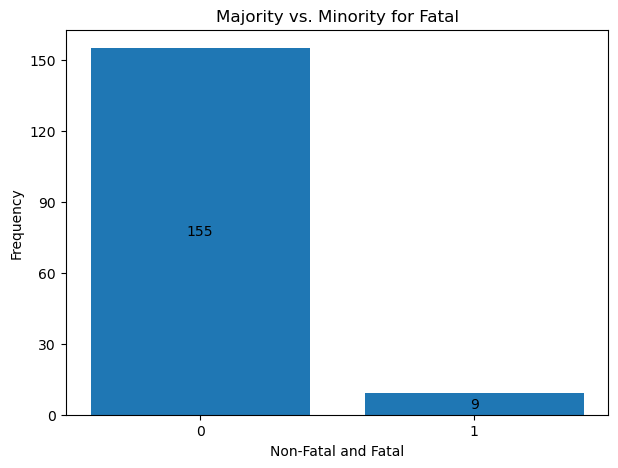

In [76]:
## Visualizing the frequency of our majority and minority class for target variable 'Fatal'

# Figure size
plt.figure(figsize=(7, 5))

# Bar plot of frequencies for 'Fatal'
plt.bar(np.arange(0,2), np.bincount(shark_df['Fatal']))

# Axis tick labels
plt.xticks([0,1])
plt.yticks(range(0, 160, 30))

# Main title and axis titles
plt.title('Majority vs. Minority for Fatal')
plt.ylabel('Frequency')
plt.xlabel('Non-Fatal and Fatal')

# Remove grid lines
plt.grid(False)

# Shows frequency inside each bar
ax = plt.subplot()
for container in ax.containers:
    ax.bar_label(container, label_type='center')

We can see above that our data is imbalanced. Our Majority class is non-fatal with `155` and our minority class has a count of `9`. That's almost a 95% to 5% split.

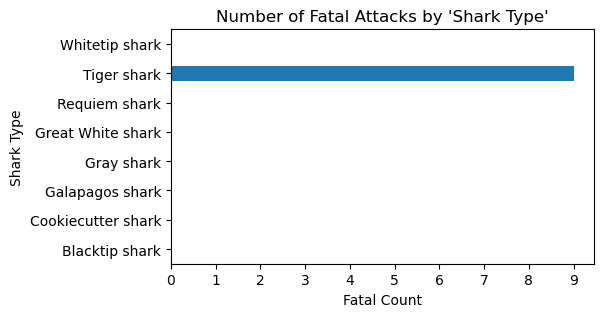

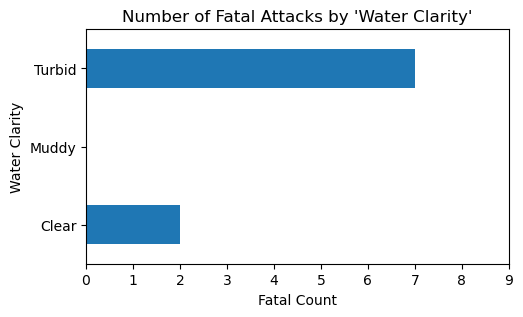

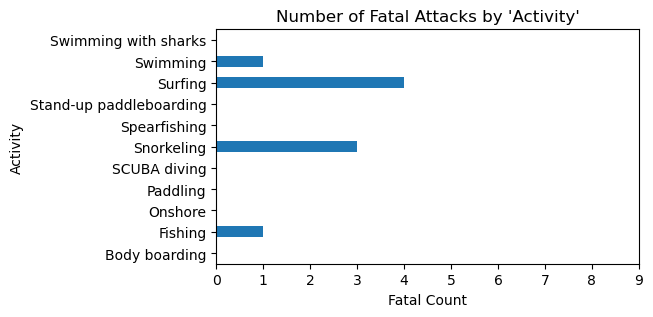

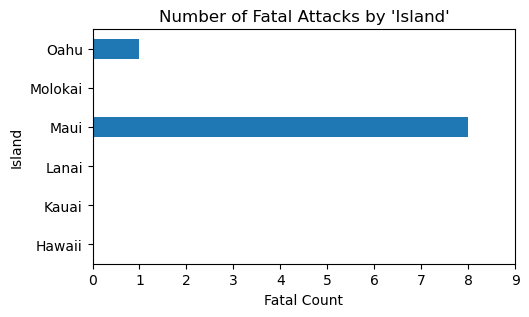

In [77]:
## Plots for each of the categorical features in regards to 'Fatal'

# List of features to loop thru
cat_features = ['Shark Type', 'Water Clarity', 'Activity', 'Island']

# Looping thru cat_feats using enumerate to provide a count for each iteration to add in our subplots
for i, feature in enumerate(cat_features):
    
    # Figure size
    fig = plt.figure(figsize=(12,14))
    
    # Creating subplots for each plot
    plt.subplot(4, 2, i+1)
    
    # Plot showing counts of each grouping of feature in regards to 'Fatal'
    shark_df.groupby(feature)['Fatal'].sum().plot.barh()
    
    # X-axis tick labels
    plt.xticks(range(0,10,1))
    
    # Formating main title with x-axis title
    plt.title(f"Number of Fatal Attacks by '{feature}'")
    plt.xlabel('Fatal Count')

The above plots shows the fatal count for each categorical feature. Our "perfect combination of conditions" for a fatal shark attack are highlighted here. `Tiger sharks` claim the only fatal attacks of all the sharks. Turbid water clarity claims `7 of 9` fatal attacks. Surfing has the highest fatal attacks with `4`. Maui contained `8 of 9` fatal attacks.

One guarantee of a fatal shark attack involves a Tiger shark! Maybe the aim should be how to predict when a Tiger shark attack will be fatal or not. With all the fatal attacks coming from a Tiger shark, it makes sense to pivot in this direction. Especially since 134 of 164 rows now involves a Tiger shark. We'd only lose 30 rows of shark attacks that are otherwise pointless given only Tiger sharks are involved in fatal attacks. I'm guessing we'd also have less outliers given the 1 foot Cookiecutter attacks happening at 2000ft water depth would not be there anymore. Another thing, our data will be a little less imbalanced by taking 30 more instances away from the majority class. It's like a natural downsampling!

The new focus, "What conditions will cause a Tiger shark attack to be a fatal attack? And can we predict it?"

In [78]:
# Returning only Tiger shark rows
shark_df = shark_df[shark_df['Shark Type'] == 'Tiger shark']

# Renaming from a copy
tiger_df = shark_df.copy()

# Size up tiger_df
tiger_df.shape

(134, 10)

In [79]:
# Descriptive statistics for each feature
tiger_df.describe(include='all')

,Activity,Water Clarity,Water Depth,Time,Month,Moon Phase,Island,Fatal,Shark Type,Shark Size
count,134,134,134.000000,134.000000,134.000000,134.000000,134,134.000000,134,134.000000
unique,10,3,NaN,NaN,NaN,NaN,6,NaN,1,NaN
top,Surfing,Turbid,NaN,NaN,NaN,NaN,Maui,NaN,Tiger shark,NaN
freq,56,79,NaN,NaN,NaN,NaN,56,NaN,134,NaN
mean,NaN,NaN,20.537313,11.873134,7.500000,0.520896,NaN,0.067164,NaN,10.089552
std,NaN,NaN,54.900136,3.445432,3.411061,0.262224,NaN,0.251245,NaN,1.651897
min,NaN,NaN,2.000000,6.000000,1.000000,0.000000,NaN,0.000000,NaN,6.000000
25%,NaN,NaN,6.000000,9.000000,5.000000,0.310000,NaN,0.000000,NaN,10.000000
50%,NaN,NaN,10.000000,11.000000,8.000000,0.555000,NaN,0.000000,NaN,10.000000
75%,NaN,NaN,20.000000,15.000000,10.000000,0.710000,NaN,0.000000,NaN,10.000000


Standard deviation for 'Water Depth' is still high but has significantly changed from `358 to 54`. You can tell that 'Shark Size' feature has a mode of `10` because the 25 and 75 percentiles are each at 10. We can also drop 'Shark Type' as this feature is no longer needed since we're only dealing with one type of shark now. 

After dropping 'Shark Type', we'll take a look at the correlations of numerical features with respect to our target variable 'Fatal'.

In [80]:
# Dropping 'Shark Type' from data
tiger_df = tiger_df.drop('Shark Type', axis=1)

# Checking that 9 features remain
tiger_df.shape[1]

9

Text(0.5, 1.0, "Numerical Features Correlating with 'Fatal'")

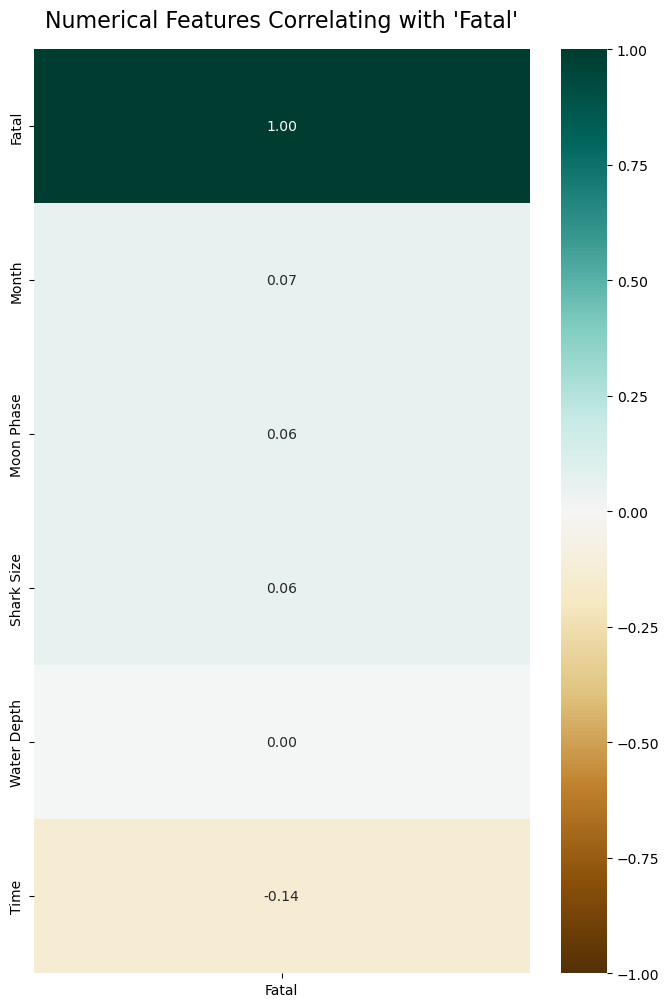

In [81]:
## Heatmap showing pearson's correlation of numerical features to our target variable 'Fatal'

# Figure size
plt.figure(figsize=(8, 12))

# Creates heatmap correlation with all features with ‘Fatal’, sorted by ‘Fatal’ in descending order,
# centers in rounded correlation values in each block
heatmap = sns.heatmap(tiger_df.corr(numeric_only=True)[['Fatal']].sort_values(by='Fatal', ascending=False),
                      vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='BrBG')

# Sets title, size and location
heatmap.set_title("Numerical Features Correlating with 'Fatal'", fontdict={'fontsize':16}, pad=16)

The above graph displays the numerical feature's correlations with 'Fatal' using Pearson's correlation and a heatmap. A stong correlation will have a value closer to 1 or -1. These features have weak correlations with 'Fatal'; the highest being 'Time' with `-0.14`.

Let's look at some of the outliers in our numerical features and see if it makes sense to treat these outlier values to improve correlations and to help model performance.

### Outlier Treatment

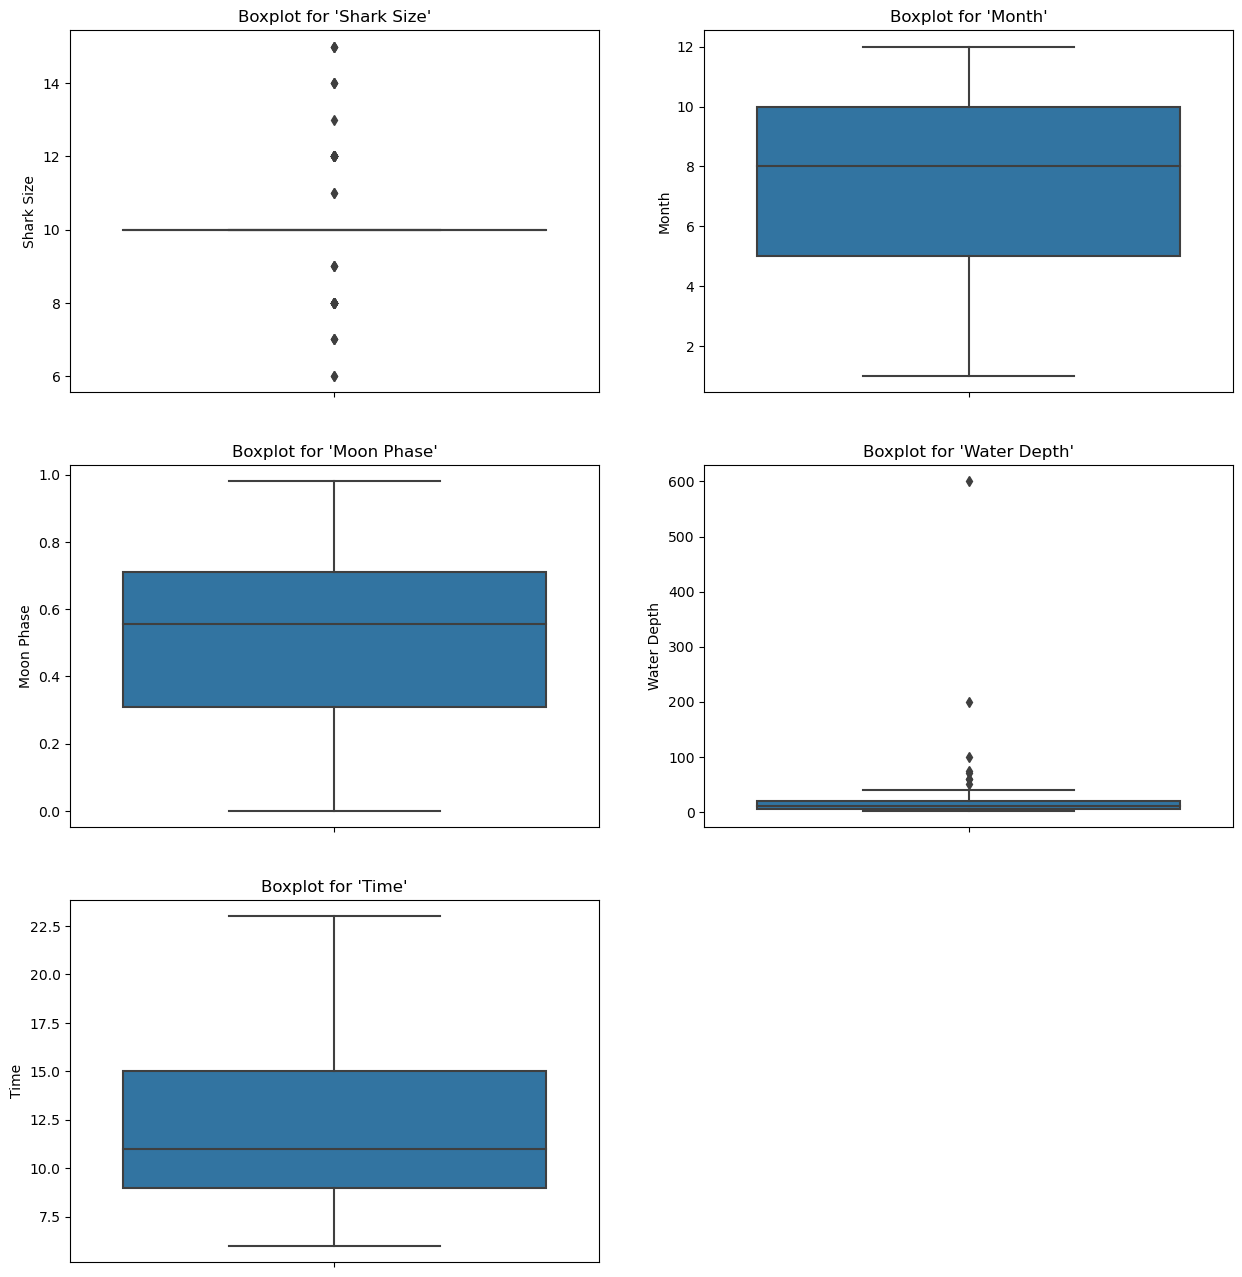

In [82]:
## Boxplot for each feature to detect outliers

# Features for outlier detection
num_features = ['Shark Size', 'Month', 'Moon Phase', 'Water Depth', 'Time']

# Figure size
fig = plt.figure(figsize=(15, 16))

# Looping thru each feature
for i, feature in enumerate(num_features):
    
    # Creating subplots for each plot
    ax = plt.subplot(3, 2, i+1)
    
    # Boxplot for each feature
    sns.boxplot(y=tiger_df[feature], ax=ax)
    
    # Formatting title for each graph
    plt.title(f"Boxplot for '{feature}'")

We can see above that 'Shark Size' and 'Water Depth' contain outliers, which are represented by the dots above or below the upper and lower bound lines. 

Every size but 10ft seems to be an outlier for 'Shark Size'! These outliers can very well be true sizes for Tiger sharks. There is not much we can do with these values. As for 'Water Depth', we will need to look more into these outlier values to see if there are incorrectly entered or measured data.

Let's view a subset of the outliers for both 'Shark Size' and 'Water Depth' by calculating the upper and lower bound lines using the inner quartile range (IQR). 

In [83]:
# Finding IQR for 'Shark Size'
q1 = tiger_df['Shark Size'].quantile(q=0.25)
q3 = tiger_df['Shark Size'].quantile(q=0.75)  
iqr = q3 - q1 

# Calculating upper and lower bound lines using IQR
upper = (q3 + 1.5 * iqr)
lower = (q1 - 1.5 * iqr)


# Subset of outliers using 'upper' and 'lower' in boolean indexing
size_outliers = tiger_df[(tiger_df['Shark Size'] > upper) | (tiger_df['Shark Size'] < lower)]

# Printing outlier values and their frequencies from subset
print('Shark size outliers and frequencies:\n-----------------------------------')
print(size_outliers['Shark Size'].value_counts().sort_index())

# Number of rows from outlier subset
print('\nNumber of outliers:\n------------------')
size_outliers.shape[0]

Shark size outliers and frequencies:
-----------------------------------
6      2
7      3
8     21
9      3
11     2
12    21
13     1
14     3
15     3
Name: Shark Size, dtype: int64

Number of outliers:
------------------


59

Tiger shark size outliers range from 6ft to 15ft. Tiger sharks are known to be within this range of sizes from aldolescence to full grown females reaching sizes upwards of 15ft. So these sizes of Tiger sharks seem to be real sizes. We'll leave this feature as is and check out 'Water Depth' next. 

In [84]:
# Finding IQR for 'Water Depth'
q1 = tiger_df['Water Depth'].quantile(q=0.25)
q3 = tiger_df['Water Depth'].quantile(q=0.75)  
iqr = q3 - q1 

# Calculating upper and lower bound lines using IQR
lower = (q1 - 1.5 * iqr)
upper = (q3 + 1.5 * iqr)
 
# Subset of outliers using 'upper' and 'lower' in boolean indexing
depth_outliers = tiger_df[(tiger_df['Water Depth'] > upper) | (tiger_df['Water Depth'] < lower)]
 
# Number of rows from outlier subset 
print('\nNumber of outliers:\n------------------')
print(depth_outliers.shape[0])

# View of subset
depth_outliers


Number of outliers:
------------------
8


,Activity,Water Clarity,Water Depth,Time,Month,Moon Phase,Island,Fatal,Shark Size
1,Swimming with sharks,Clear,600,13,6,0.02,Oahu,0,10
11,Stand-up paddleboarding,Clear,200,11,2,0.96,Maui,0,15
15,Surfing,Clear,60,11,10,0.75,Oahu,0,8
24,Swimming,Clear,60,8,4,0.27,Hawaii,0,10
82,Fishing,Clear,100,10,12,0.97,Maui,1,10
139,Snorkeling,Clear,50,8,6,0.80,Oahu,0,14
153,Surfing,Clear,70,11,8,0.51,Maui,0,12
158,Swimming,Clear,75,10,3,0.57,Maui,0,10


There are 8 rows containing outliers under 'Water Depth' feature. Two occurrences of a shark attack while surfing happened at 60 and  70 feet. These two entries would be rare in itself. [Here](https://surfsimply.com/magazine/why-and-how-waves-break#) is one of many resources stating that waves form when the water depth is 1.3 times the height of the wave. Meaning, if the water is 60 and 70 feet deep, the wave heights would be 46 and 54 feet respectively. Although these wave heights are not unheard of in hawaii, it is still rare. Sometimes there is a deep trench in the seabed before the shallow areas where waves break and this could be a possible misconception for water depth for these two entries. A surfer would be where the waves are breaking (in the shallows), not hovering over the trench. We'll go ahead and impute these two values with the mode water depth for surfing.

Another thing is I want a machine learning model that would predict whether a tiger shark attack would be fatal or not for the everyday unprovoked scenario's like surfing or swimming. 'Swimming with sharks' would be considered a provoked scenario because you would be chumming the water to attract the sharks to you, which wouldn't represent the idea behind the model. Removing rows where 'Activity' is equal to 'Swimming with sharks' would kill two birds with one stone by removing provoked attacks and removing our highest outlier in 'Water Depth'.

In [85]:
# groupby object grouping by 'Activity'
activity_group = tiger_df.groupby('Activity')

# Returns 'Water Depth' mode for surfing by grabbing 'Surfing' from activity_group 
surf_depth_mode = activity_group['Water Depth'].get_group('Surfing').mode()[1]

# Imputing surfing water depth outliers with surf_depth_mode
tiger_df.loc[(tiger_df['Activity'] == 'Surfing') & (tiger_df['Water Depth'] == 60), 'Water Depth'] = surf_depth_mode
tiger_df.loc[(tiger_df['Activity'] == 'Surfing') & (tiger_df['Water Depth'] == 70), 'Water Depth'] = surf_depth_mode

In [86]:
# Removing rows where 'Activity' equals 'Swimming with sharks'
tiger_df = tiger_df[tiger_df['Activity'] != 'Swimming with sharks']

# Confirming row drop with 133 
tiger_df.shape[0]

133

In [87]:
# Making sure outliers are treated
tiger_df['Water Depth'].unique()

array([ 10,   6,   4,  20, 200,  60,  25,  15,   3,  12,   8,  40,  30,
         7,   5, 100,  35,   2,  50,  75])

In [88]:
# Confirming 60ft instance is not surfing
tiger_df[tiger_df['Water Depth'] == 60]

,Activity,Water Clarity,Water Depth,Time,Month,Moon Phase,Island,Fatal,Shark Size
24,Swimming,Clear,60,8,4,0.27,Hawaii,0,10


In [89]:
# Resetting index
tiger_df = tiger_df.reset_index(drop=True)

tiger_df.head()

,Activity,Water Clarity,Water Depth,Time,Month,Moon Phase,Island,Fatal,Shark Size
0,Surfing,Turbid,10,12,6,0.56,Oahu,1,10
1,Surfing,Turbid,10,16,3,0.78,Oahu,0,10
2,Surfing,Turbid,6,11,12,0.58,Maui,1,10
3,Surfing,Turbid,4,15,10,0.35,Oahu,0,8
4,Surfing,Turbid,20,16,10,0.01,Kauai,0,10


Above, our numerical feature correlations with 'Fatal' were pretty weak to say the least. Let's graph each of the features in regards to 'Fatal' to see if there are any trends beyond the correlations.

([<matplotlib.axis.YTick at 0x1567bf610>,
 [Text(0, 0, '0'), Text(0, 1, '1'), Text(0, 2, '2')])

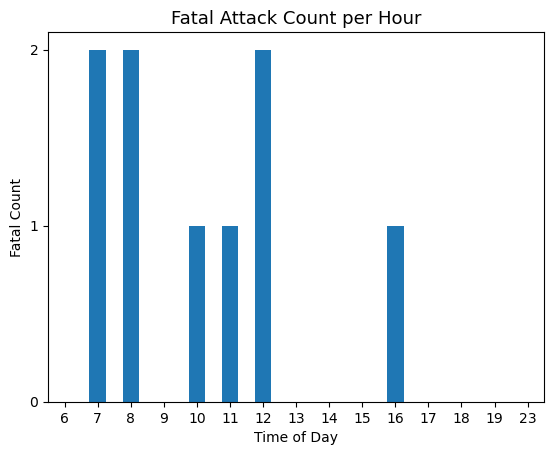

In [90]:
# Bar plot of 'Time' against Fatal count
tiger_df.groupby('Time')['Fatal'].sum().plot.bar()

# Title and axis labels
plt.xlabel('Time of Day')
plt.ylabel('Fatal Count')
plt.title('Fatal Attack Count per Hour', size=13)

# X-tick labels rotated normal
plt.xticks(rotation=0)

# Y-tick labels
plt.yticks([0,1,2])

The above graph depicts fatal attacks by time. We see that the times with the most fatal attacks are in the first half of the day between 7am and around noon. Only one fatal attack is after noon at 4pm.

Since there is a spread of fatal attacks throughout the morning, it would make sense to group these times into different time of days like morning, evenings, ect. Each time of day group will be designated as follows: `Morning = 6 to 12, Afternoon = 13 to 17, Evening = 18 to 21, and Night = 22 to 5`.

In [91]:
# Function to convert times to different time of days
def time_of_day(value):
    if value > 5 and value <= 12:
        value = 'Morning'
    elif value > 12 and value <= 17 :
        value = 'Afternoon'
    elif value > 17 and value <= 21:
        value = 'Evening'
    else:
        value = 'Night'
        
    return value

# Applying function to 'Time'
tiger_df['Time'] = tiger_df['Time'].apply(time_of_day)

In [92]:
# New distribution of 'Time'
tiger_df['Time'].value_counts()

Morning      77
Afternoon    51
Evening       4
Night         1
Name: Time, dtype: int64

Most attacks happen in the morning or afternoon hours of the day. We'll visualize the new distribution of 'Time' in relation to fatal attacks below.

([<matplotlib.axis.XTick at 0x1567b01d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

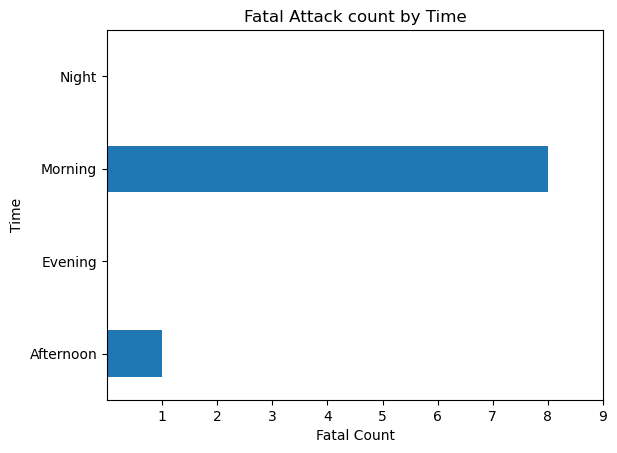

In [93]:
# Plot for total fatal attacks per time of day
tiger_df.groupby('Time')['Fatal'].sum().plot.barh()

# Title and axis labels
plt.title('Fatal Attack count by Time')
plt.xlabel('Fatal Count')
plt.ylabel('Time')

# X-tick labels
plt.xticks(range(1,10))

`8 of 9` fatal attacks happen in the morning.

Moving on to 'Month' feature in relation to fatal attacks.

([<matplotlib.axis.YTick at 0x1566f2290>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

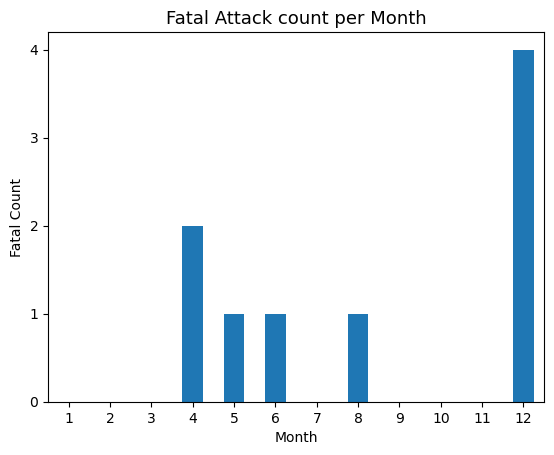

In [94]:
# Bar plot of 'Month' against Fatal count
tiger_df.groupby('Month')['Fatal'].sum().plot.bar()

# Title and axis labels
plt.xlabel('Month')
plt.ylabel('Fatal Count')
plt.title('Fatal Attack count per Month', size=13)

# X-tick labels rotated normal
plt.xticks(rotation=0)

# Y-tick labels
plt.yticks([0,1,2,3,4])

The above bar plot depicts fatal attacks by month. Although there isn't a clear trend of attacks here, December has the most fatal attacks with 4.  Let's see if the distribution of attacks per month match up with our fatal attacks per month.

([<matplotlib.axis.XTick at 0x1565d2810>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

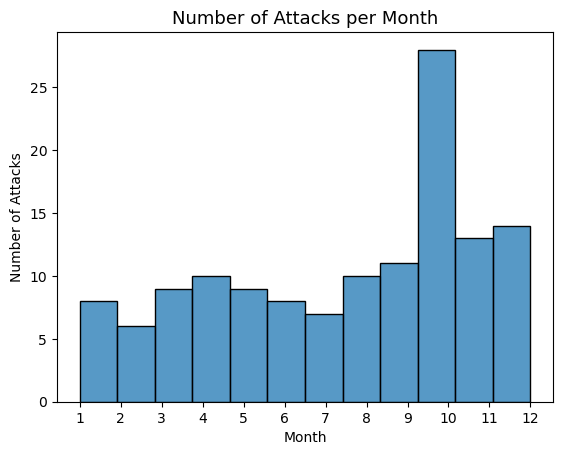

In [95]:
# Histogram of 'Month' to see highest month frequency
sns.histplot(data=tiger_df, x='Month', bins=12)

# Title and axis labels
plt.xlabel('Month')
plt.ylabel('Number of Attacks')
plt.title('Number of Attacks per Month', size=13)

# X-tick labels
plt.xticks(range(1,13))

December is the second highest count of attacks but clearly not the most by about double. The most attacks happen in October but there are no recorded fatal attacks in this month.

Let's check out 'Water Depth' in relation to 'Fatal' next.

([<matplotlib.axis.YTick at 0x156bed590>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

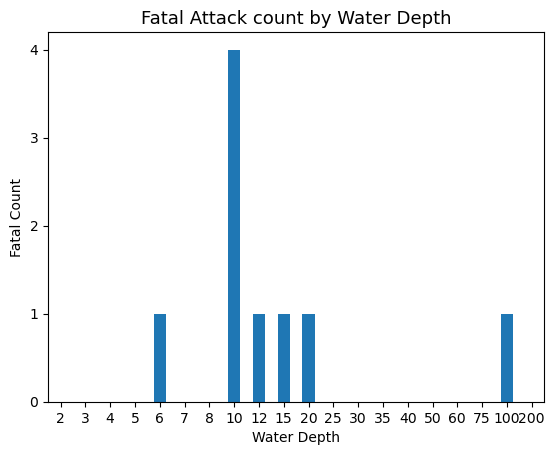

In [96]:
# Bar plot of 'Water Depth' against Fatal count
tiger_df.groupby('Water Depth')['Fatal'].sum().plot.bar()

# Title and axis labels
plt.xlabel('Water Depth')
plt.ylabel('Fatal Count')
plt.title('Fatal Attack count by Water Depth', size=13)

# X-tick labels rotated normal
plt.xticks(rotation=0)

# Y-tick labels
plt.yticks([0,1,2,3,4])

Water depth at 10ft has the highest fatal attacks with 4. While most of the fatal attacks happen at 20ft and under, we have our outlier showing a fatal attack at 100ft. We'll see if this affects our model predictions or not.

Moving on the 'Moon Phase' in relation to 'Fatal'.

([<matplotlib.axis.XTick at 0x156bc7fd0>,
 [Text(0.0, 0, '0.0'),
  Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.3, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6'),
  Text(0.7, 0, '0.7'),
  Text(0.8, 0, '0.8'),
  Text(0.9, 0, '0.9'),
  Text(1.0, 0, '1.0')])

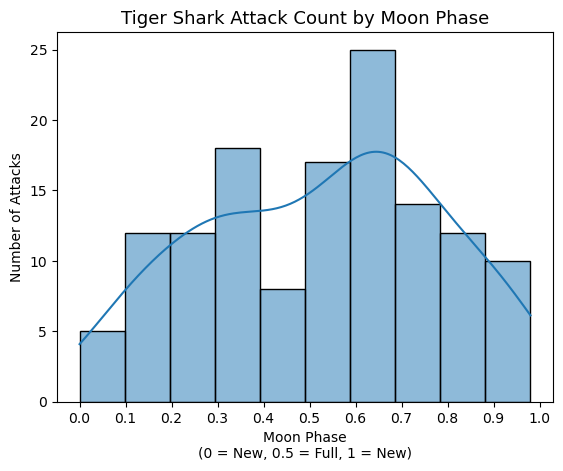

In [97]:
# Histogram of 'Moon Phase' with 10 bins and showing kde for distibution shape
sns.histplot(data=tiger_df, x='Moon Phase', bins=10, kde=True)

# Title and axis labels
plt.xlabel('''Moon Phase
(0 = New, 0.5 = Full, 1 = New)''')
plt.ylabel('Number of Attacks')
plt.title('Tiger Shark Attack Count by Moon Phase', size=13)

# X-tick labels
plt.xticks([0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0],rotation=0)

The histogram above shows the distribution of moon phases using 10 bins. The distribution is almost a normal distribution meaning, the distribution is symmetrical around the mean. In our case the mean is `0.52`, almost right in the middle of our moon phase's range. Let's see where fatal attacks fall under moon phases.

In [98]:
# Mask where 'Fatal' equals 1
fatal_mask = tiger_df[tiger_df['Fatal'] == 1]

# Looking at moon phases using fatal mask
fatal_moon_phase = fatal_mask['Moon Phase']

fatal_moon_phase

0      0.56
2      0.58
8      0.48
17     0.77
27     0.68
53     0.35
62     0.97
67     0.24
108    0.58
Name: Moon Phase, dtype: float64

We see that a lot of the fatal attacks happen close to our mean moon phase which would be close to a full moon. To help our model identify moon phase patterns for better performance, we will be binning this feature into different moon phase groups. We'll narrow down the moon phases and add phases first quarter and last quarter. Right now we have 0 = New moon, 0.5 = Full moon, and 1 = New moon. We'll add first quarter phase inbetween our first new moon and full moon and last quarter phase after full moon. Now we have four moon phases we'll split into equal intervals of 0.25. Each group will be designated as follows: `[0, 0.12) = New moon, (0.12, 0.37] = First quarter, (0.37, 0.62] = Full moon, [0.62, 0.87) = Last quarter, and [0.87, 1] = New moon`. So if a fatal attack falls under 'New moon', we'll say this attack happened _around_ a new moon.

In [99]:
# Function to convert each value within the interval range in 'Moon Phase' to their corresponding groups
def moon_cat(value):
    if value >= 0 and value < 0.12:
        value = 'New moon'
    elif value >= 0.12 and value < 0.37:
        value = 'First quarter'
    elif value >= 0.37 and value < 0.62:
        value = 'Full moon'
    elif value >= 0.62 and value < 0.87:
        value = 'Last quarter'
    else:
        value = 'New moon'
        
    return value

# Applying function to 'Moon Phase'
tiger_df['Moon Phase'] = tiger_df['Moon Phase'].apply(moon_cat)

In [100]:
# New distribution for 'Moon Phase'
tiger_df['Moon Phase'].value_counts()

Last quarter     42
Full moon        36
First quarter    31
New moon         24
Name: Moon Phase, dtype: int64

Most of the attacks happen around the last quarter phase followed by full moon phase. While the least amount of attacks happens around a new moon where the illumintion is close to none. Let's see what moon phases fatal attacks fall under. 

([<matplotlib.axis.XTick at 0x157657550>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

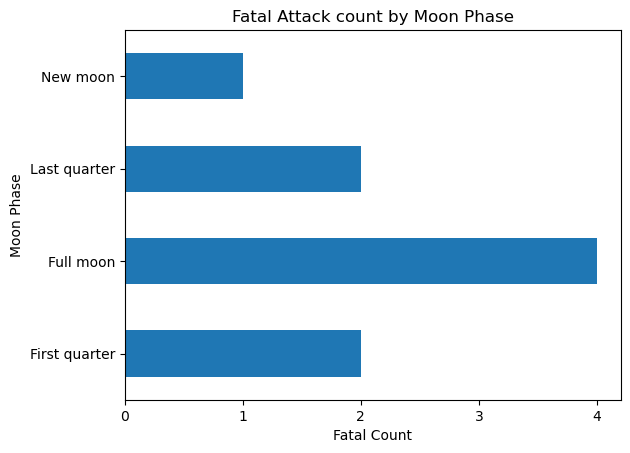

In [101]:
# Plot for total fatal attacks per moon phase
tiger_df.groupby('Moon Phase')['Fatal'].sum().plot.barh()

# Title and axis labels
plt.title('Fatal Attack count by Moon Phase')
plt.xlabel('Fatal Count')
plt.ylabel('Moon Phase')

# X-tick labels
plt.xticks([0,1,2,3,4])

A majority of fatal Tiger shark attacks happen more so when the moon is illuminated than not (like new moon) with most of them happening around a full moon.

# Feature Engineering

In [102]:
# Quick look at tiger_df
tiger_df.head(2)

,Activity,Water Clarity,Water Depth,Time,Month,Moon Phase,Island,Fatal,Shark Size
0,Surfing,Turbid,10,Morning,6,Full moon,Oahu,1,10
1,Surfing,Turbid,10,Afternoon,3,Last quarter,Oahu,0,10


For our machine learning models to properly work, we need to implement one hot encoding on our categorical features. One hot encoding will convert our categorical features into numerical format so they can be used in our machine learing models. We will implement one hot encoding using panda's `get_dummies` method.

In [103]:
# Copy of tiger_df to preserve original
dummy_df = tiger_df.copy()

# Mapping for 'Month' feature to implement one hot encoding
month_mapping = {1: 'January', 2: 'February', 3: 'March',
                 4: 'April', 5: 'May', 6: 'June', 7: 'July',
                 8: 'August', 9: 'September', 10: 'October',
                 11: 'November', 12: 'December'}

# Applying mapping to 'Month' 
dummy_df['Month'] = dummy_df['Month'].replace(month_mapping)

# Using pandas get_dummies to convert categorical features to numerical format, dropping first column
dummies = pd.get_dummies(dummy_df[['Activity', 'Water Clarity', 'Time', 'Month', 'Moon Phase', 'Island']],  drop_first=True)

# Combining dummy_df and dummies
dummy_df = pd.concat([dummy_df, dummies], axis=1)

# Dropping original features that are no longer needed
dummy_df = dummy_df.drop(['Activity', 'Water Clarity', 'Time', 'Month', 'Moon Phase', 'Island'], axis=1)

# Displing max amount of columns for jupyter's output
pd.set_option('display.max_columns', None)

# Checking work
dummy_df.head(5)

,Water Depth,Fatal,Shark Size,Activity_Fishing,Activity_Onshore,Activity_Paddling,Activity_Snorkeling,Activity_Spearfishing,Activity_Stand-up paddleboarding,Activity_Surfing,Activity_Swimming,Water Clarity_Muddy,Water Clarity_Turbid,Time_Evening,Time_Morning,Time_Night,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Moon Phase_Full moon,Moon Phase_Last quarter,Moon Phase_New moon,Island_Kauai,Island_Lanai,Island_Maui,Island_Molokai,Island_Oahu
0,10,1,10,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,10,0,10,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
2,6,1,10,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,4,0,8,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,20,0,10,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0


Next, let's visualize our two numerical feature's distributions via histogram. We'll be looking at the distribution shapes by setting `kde=True` to decide whether we should scale our data, and if so, which scaler to use.

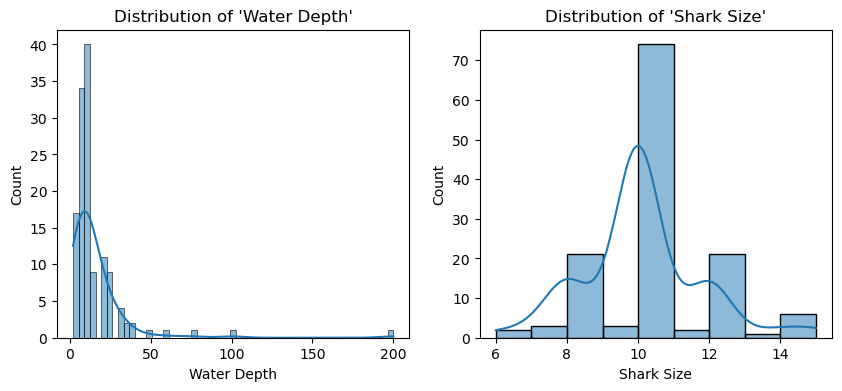

In [104]:
# List of numerical features to loop thru
num_feats = ['Water Depth', 'Shark Size']

# Figure size for plots
plt.figure(figsize=(10, 4))

# Loop thru each numerical feature
for i, feature in enumerate(num_feats):
    
    # Subplots for each plot
    plt.subplot(1, 2, i+1)

    # Histogram with kde to show distribution shape
    sns.histplot(data=dummy_df, x=feature, kde=True)
    
    # Title's for each plot
    plt.title(f"Distribution of '{feature}'")

For 'Water Depth' we have ranges upwards of 200 and 'Shark Size' with a max range around 14. We should definitely use a scaler and since we are dealing with outliers (remember back to our boxplots above) we'll be using the `Robust Scaler`. The Robust Scaler scales the data around the medians using the IQR which will preserve the distribution shapes without being distorted by outliers.

In [105]:
# Importing Robust Scaler from scikit learn
from sklearn.preprocessing import RobustScaler

# Dataset of the numerical features only
num_only_df = dummy_df[['Water Depth', 'Shark Size']]

# Instantiating the scaler
scaler = RobustScaler()

# Applying the scaler to our data
scaled_df = scaler.fit_transform(num_only_df)

# Converting back to a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=num_only_df.columns)

# Checking work
scaled_df.head()

,Water Depth,Shark Size
0,0.000000,0.0
1,0.000000,0.0
2,-0.444444,0.0
3,-0.666667,-2.0
4,1.111111,0.0


Features are now scaled. Let's check out their distribution shapes once again.

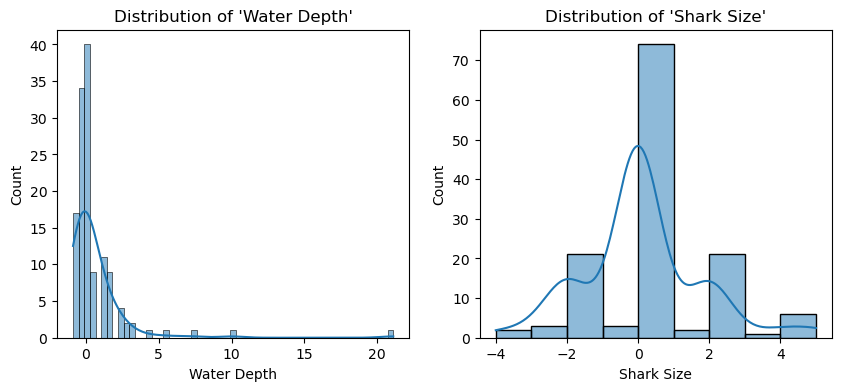

In [106]:
# List of numerical features to loop thru
num_feats = ['Water Depth', 'Shark Size']

# Figure size for plots
plt.figure(figsize=(10, 4))

# Loop thru each numerical feature
for i, feature in enumerate(num_feats):
    
    # Subplots for each plot
    plt.subplot(1, 2, i+1)

    # Histogram with kde to show distribution shape using scaled data
    sns.histplot(data=scaled_df, x=feature, kde=True)
    
    # Title's for each plot
    plt.title(f"Distribution of '{feature}'")

As we can see, their distribution shapes remain the same as before but with scaled data now. Let's combine our scaled data, `scaled_df`, to `dummy_df`'s dataset to make our final machine learning ready dataset.

In [107]:
# Dropping original features that are no longer needed to add scaled version of features
dummy_df = dummy_df.drop(['Water Depth', 'Shark Size'], axis=1)

# Combining dummy_df and scaled numerical features, scaled_df
final_df = pd.concat([dummy_df, scaled_df], axis=1)

# Checking work
final_df.head()

,Fatal,Activity_Fishing,Activity_Onshore,Activity_Paddling,Activity_Snorkeling,Activity_Spearfishing,Activity_Stand-up paddleboarding,Activity_Surfing,Activity_Swimming,Water Clarity_Muddy,Water Clarity_Turbid,Time_Evening,Time_Morning,Time_Night,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Moon Phase_Full moon,Moon Phase_Last quarter,Moon Phase_New moon,Island_Kauai,Island_Lanai,Island_Maui,Island_Molokai,Island_Oahu,Water Depth,Shark Size
0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0.000000,0.0
1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0.000000,0.0
2,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,-0.444444,0.0
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.666667,-2.0
4,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1.111111,0.0


# Building Logistic Regression Model

We will begin by building a logistic regression model using scikit-learn. The data will be split into training and test sets, ensuring a balanced distribution of both the majority and minority classes in each set.

In [108]:
# Importing LogisticRegression from scikit-learn
from sklearn.linear_model import LogisticRegression

# Importing train_test_split from scikit learn 
from sklearn.model_selection import train_test_split

# Separating predictors and target variable for model
X = final_df.drop('Fatal', axis=1)
y = final_df['Fatal']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=14)

# Making sure each set contains positive class instances
train_minority = sum(y_train == 1)
train_majority = sum(y_train == 0)
test_minority = sum(y_test == 1)
test_majority = sum(y_test == 0)

# Printing each sets positive counts
print(f'Train Majority Count: {train_majority}\nTrain Minority Count: {train_minority}\n')
print(f'Test Majority Count: {test_majority}\nTest Minority Count: {test_minority}')

Train Majority Count: 88
Train Minority Count: 5

Test Majority Count: 36
Test Minority Count: 4


To alleviate class imbalance, it would make sense to upweight the minority class as compared to downsampling the majority class given how little data there is. But first we'll build a model without upweighting and rely on metrics other than accuracy like sensitivity, specificity, precision, and F1 score. Then we'll try upweighting, but in two different ways. The first way we'll be using the parameter `class_weight='balanced'` in scikit-learn's `LogisticRegression` class to balance the minority class inversely proportional to the majority class. The second way we'll be creating a new dataframe by adding random samples of the minority class to equal the majority class so we have a balanced dataframe. This method will change our model slightly from the first weighted one so we have a different version to compare to.

We won't be able to compare accuracy scores with the first unweighted model, but we'll be able to compare all the other metrics amoung all three models. Precision, sensitivity, and F1 score will be more important metrics in our case because we want to be able to predict when a Tiger shark attack will be fatal. This involves predicting the positive class (1).

Here is a key to the prediction types we'll use for finding certain metrics:

* Positive = 1 label
* Negative = 0 label
<br/>

* True Positive (tp) - you predicted positive and it’s actually positive 
* True Negative (tn) - you predicted negative and it’s actually negative
* False Positive (fp) - you predicted positive and it’s actually negative
* False Negative (fn) - you predicted negative and it’s actually positive

Here are the metrics:

* Accuracy - measures the percentage of observations that had the correct prediction
* Sensitivity -  measures the percentage of predicted positive class (1) when its supposed to be positive
* Specificity - measures the percentage of predicted negative class (0) when it supposed to be negative
* Precision - measures the percentage of predicted correct positive class (1) of all the positive predictions
* F1 Score - harmonic mean of precision and sensitivity

## Model 1 Without Weights

In [109]:
# Instantiating model 1 without weights and a max_iter of 500 to avoid convergance error
model_1 = LogisticRegression(max_iter=500, random_state=111)

# Fitting model to data
model_1.fit(X_train, y_train)

# Model predictions to calculate various metrics
y_pred = model_1.predict(X_train)

# Try and except to see if there's enough data to predict positive class
# Sensitivity score
tp = sum((y_train == 1) & (y_pred == 1))
fn = sum((y_train == 1) & (y_pred == 0))
sensitivity = tp / (tp + fn)

# Specificity score
tn = sum((y_train == 0) & (y_pred == 0))
fp = sum((y_train == 0) & (y_pred == 1))
specificity = tn / (tn + fp)

# try and except clause for these metrics
try:
    # Precision score
    precision = tp / (tp + fp)

    # F1 score
    f1_score = (2 * sensitivity * precision) / (sensitivity + precision)

except ZeroDivisionError:
    print('Error: division by zero\n')
    
# Printing formatted scores
print(f'''Model 1\n--------
Sensitivity: {sensitivity * 100:.2f}%
Specificity: {specificity * 100:.2f}%
Precision: Error
F1 Score: Error''')

Error: division by zero

Model 1
--------
Sensitivity: 0.00%
Specificity: 100.00%
Precision: Error
F1 Score: Error


In [110]:
# Checking model 1 predictions
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 0
True Negative: 88
False Positive: 0
False Negative: 5


There is a 'division by zero' error in calculating precision. There are `0` true positives and false positives due to the imbalance of the data. In other words the model is struggling to find meaningful patterns in the data to make accurate predictions.

Let's try adding weight to our minority class in our next model.

## Model 2 with Upweighting Using Parameter

We'll start upweighting our model using the parameter in LogisticRegression called `class_weight`. Setting this parameter to 'balanced' will adjust class weights inversely proportional to class frequencies, or manipulating the minority class.

In [111]:
# Instantiating model 2 with balanced classes, and a max_iter of 500 to avoid convergance error
model_2 = LogisticRegression(class_weight='balanced', max_iter=500, random_state=111)

# Fitting model to data
model_2.fit(X_train, y_train)

# Model predictions on X_train to calculate various metrics
y_pred = model_2.predict(X_train)

# Accuracy score
accuracy = model_2.score(X_train, y_train)

# Sensitivity score
tp = sum((y_train == 1) & (y_pred == 1))
fn = sum((y_train == 1) & (y_pred == 0))
sensitivity = tp / (tp + fn)

# Specificity score
tn = sum((y_train == 0) & (y_pred == 0))
fp = sum((y_train == 0) & (y_pred == 1))
specificity = tn / (tn + fp)

# Precision score
precision = tp / (tp + fp)

# F1 score
f1_score = (2 * sensitivity * precision) / (sensitivity + precision)

# Printing formatted scores
print(f'''Model 2 Training Scores\n--------
Accuracy score: {accuracy * 100:.2f}%
Sensitivity: {sensitivity * 100:.2f}%
Specificity: {specificity * 100:.2f}%
Precision: {precision * 100:.2f}%
F1 Score: {f1_score * 100:.2f}%''')

Model 2 Training Scores
--------
Accuracy score: 93.55%
Sensitivity: 100.00%
Specificity: 93.18%
Precision: 45.45%
F1 Score: 62.50%


In [112]:
# Model predictions on X_test to calculate various metrics
y_pred = model_2.predict(X_test)

# Accuracy score
accuracy = model_2.score(X_test, y_test)

# Sensitivity score
tp = sum((y_test == 1) & (y_pred == 1))
fn = sum((y_test == 1) & (y_pred == 0))
sensitivity = tp / (tp + fn)

# Specificity score
tn = sum((y_test == 0) & (y_pred == 0))
fp = sum((y_test == 0) & (y_pred == 1))
specificity = tn / (tn + fp)

# Precision score
precision = tp / (tp + fp)

# F1 score
f1_score = (2 * sensitivity * precision) / (sensitivity + precision)

# Printing formatted scores
print(f'''Model 2 Test Scores\n--------
Accuracy score: {accuracy * 100:.2f}%
Sensitivity: {sensitivity * 100:.2f}%
Specificity: {specificity * 100:.2f}%
Precision: {precision * 100:.2f}%
F1 Score: {f1_score * 100:.2f}%''')

Model 2 Test Scores
--------
Accuracy score: 92.50%
Sensitivity: 75.00%
Specificity: 94.44%
Precision: 60.00%
F1 Score: 66.67%


In [113]:
# Instatiating list of lists with metric scores for viewing
scores = [[93.55, 100, 93.18, 45.45, 62.50], 
                 [92.50, 75, 94.44, 60.00, 66.67]]

# Coverting to df With column and index names to visualize model differences
model_scores = pd.DataFrame(data=scores, 
                            columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score'],
                            index=['Train Model 2', 'Test Model 2'])

model_scores

,Accuracy,Sensitivity,Specificity,Precision,F1 Score
Train Model 2,93.55,100,93.18,45.45,62.50
Test Model 2,92.50,75,94.44,60.00,66.67


In [114]:
# Checking model 2 predictions
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 3
True Negative: 34
False Positive: 2
False Negative: 1


Model 2 performed better with upweighting. This model generalized well with a test accuracy of `92.50%`. The F1 score is slighlty higher in the test model than the training model due to the random split of data. The F1 score and precision are on the low side due to the model not being able to accurately predict true positives.

Let's try method two for our weighted model next.

## Model 3 with Upsampling

We'll call this version of our weighted model our upsampling model, since we will be creating random samples of the minority class to balance with the majority class. We'll use `resample` from scikit-learn's `utils` library to create a new dataframe with balanced classes. This method will use a different variety of samples than model 2's 'balanced' parameter, which could lead to different scores. Let's see.

In [115]:
# Importing resample 
from sklearn.utils import resample

# Separating minority and majority classes
minority_class = final_df[final_df['Fatal'] == 1]
majority_class = final_df[final_df['Fatal'] == 0]

# Creating 124 samples of the minority class with replacement
new_minority_class = resample(minority_class, replace=True, n_samples=124, random_state=111)

# Creating new df by adding majority class and the new samples of the minority class
df_balanced = pd.concat([majority_class, new_minority_class])

# Separating predictors and target variable for model using balanced_df
X_b = df_balanced.drop('Fatal', axis=1)
y_b = df_balanced['Fatal']

# Printing previous and new class counts
print(f'''Number of previous minority observations: {minority_class.shape[0]}
Number of majority observations: {majority_class.shape[0]}

Number of new minority observations in balanced_df: {new_minority_class.shape[0]}''')

Number of previous minority observations: 9
Number of majority observations: 124

Number of new minority observations in balanced_df: 124


In [116]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.20, random_state=111)

# Making sure each set contains positive class instances
train_positive = sum(y_train == 1)
train_negative = sum(y_train == 0)
test_positive = sum(y_test == 1)
test_negative = sum(y_test == 0)

# Printing each sets positive counts
print(f'Train Negative Count: {train_negative}\nTrain Positive Count: {train_positive}\n')
print(f'Test Negative Count: {test_negative}\nTest Positive Count: {test_positive}')

Train Negative Count: 94
Train Positive Count: 104

Test Negative Count: 30
Test Positive Count: 20


There is a pretty balanced amount of positive and negative classes in each of the training and test sets.

In [117]:
# Instantiating model 3 with a max_iter of 500 to avoid convergance error
model_3 = LogisticRegression(max_iter=500, random_state=111)

# Fitting model to data
model_3.fit(X_train, y_train)

# Model predictions on X_train to calculate various metrics
y_pred = model_3.predict(X_train)

# Accuracy score
accuracy = model_3.score(X_train, y_train)

# Sensitivity score
tp = sum((y_train == 1) & (y_pred == 1))
fn = sum((y_train == 1) & (y_pred == 0))
sensitivity = tp / (tp + fn)

# Specificity score
tn = sum((y_train == 0) & (y_pred == 0))
fp = sum((y_train == 0) & (y_pred == 1))
specificity = tn / (tn + fp)

# Precision score
precision = tp / (tp + fp)

# F1 score
f1_score = (2 * sensitivity * precision) / (sensitivity + precision)

# Printing formatted scores
print(f'''Model 3 Train\n--------
Accuracy score: {accuracy * 100:.2f}%
Sensitivity: {sensitivity * 100:.2f}%
Specificity: {specificity * 100:.2f}%
Precision: {precision * 100:.2f}%
F1 Score: {f1_score * 100:.2f}%''')

Model 3 Train
--------
Accuracy score: 94.95%
Sensitivity: 100.00%
Specificity: 89.36%
Precision: 91.23%
F1 Score: 95.41%


In [118]:
# Model predictions on X_test to calculate various metrics
y_pred = model_3.predict(X_test)

# Accuracy score
accuracy = model_3.score(X_test, y_test)

# Sensitivity score
tp = sum((y_test == 1) & (y_pred == 1))
fn = sum((y_test == 1) & (y_pred == 0))
sensitivity = tp / (tp + fn)

# Specificity score
tn = sum((y_test == 0) & (y_pred == 0))
fp = sum((y_test == 0) & (y_pred == 1))
specificity = tn / (tn + fp)

# Precision score
precision = tp / (tp + fp)

# F1 score
f1_score = (2 * sensitivity * precision) / (sensitivity + precision)

# Printing formatted scores
print(f'''Model 3 Test\n--------
Accuracy score: {accuracy * 100:.2f}%
Sensitivity: {sensitivity * 100:.2f}%
Specificity: {specificity * 100:.2f}%
Precision: {precision * 100:.2f}%
F1 Score: {f1_score * 100:.2f}%''')

Model 3 Test
--------
Accuracy score: 92.00%
Sensitivity: 100.00%
Specificity: 86.67%
Precision: 83.33%
F1 Score: 90.91%


Model 3 excels in every metric compared to model 2. Take a look below:

In [119]:
# Instatiating list of lists with metric scores for viewing
scores = [[94.95, 100, 89.36, 91.23, 95.41], 
                 [92, 100, 86.67, 83.33, 90.91]]

# Coverting to df With column and index names to visualize model differences
model3_scores = pd.DataFrame(data=scores, 
                            columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score'],
                            index=['Train Model 3', 'Test Model 3'])

model3_scores

,Accuracy,Sensitivity,Specificity,Precision,F1 Score
Train Model 3,94.95,100,89.36,91.23,95.41
Test Model 3,92.00,100,86.67,83.33,90.91


In [120]:
# Checking model 3 predictions
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 20
True Negative: 26
False Positive: 4
False Negative: 0


Model 3 generalized and performed exceptionally well with a test accuracy of `92%`. The great thing in this model that model 2 doesn't have is that model 3 is predicting all of its true positive class correctly. The false positive prediction rate is lower in this model too giving a higher precision and F1 score. 

I'm pretty happy with this model, but let's explore if any further adjustments can be made through hyperparameter tuning using GridSearchCV from scikit-learn to maximize its predictive performance with our data.

# GridSearchCV

In our grid search we'll use the hyperparameters `solver`, `penalty`, and `C` to find the best algorithm, regularization technique, and  regularization strength respectively.

In [149]:
# Importing GridSearchCV from scikit-learn
from sklearn.model_selection import GridSearchCV

# Instantiating model with max_iter of 10000 to avoid convergance error
lr = LogisticRegression(max_iter=10000, random_state=111)

# Parameters to check
params = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'C' : [0.01, 0.1, 1, 10, 100],
        'penalty' : ['l1', 'l2', 'elasticnet', None]}

# Instantiating GridSearchCV with parameters and 'folds'
grid_model = GridSearchCV(estimator=lr, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting training data
grid_model.fit(X_train, y_train)

# Returning accuracy score and best params 
best_score = grid_model.best_score_
best_params = grid_model.best_params_

# Predictions from grid model's best parameters using test data to calculate other metrics
y_pred = grid_model.best_estimator_.predict(X_test)

# Sensitivity score
tp = sum((y_test == 1) & (y_pred == 1))
fn = sum((y_test == 1) & (y_pred == 0))
sensitivity = tp / (tp + fn)

# Specificity score
tn = sum((y_test == 0) & (y_pred == 0))
fp = sum((y_test == 0) & (y_pred == 1))
specificity = tn / (tn + fp)

# Precision score
precision = tp / (tp + fp)

# F1 score
f1_score = (2 * sensitivity * precision) / (sensitivity + precision)

# Printing formatted scores
print(f'''grid_model \n-----------
Best Parameters: {best_params}\n
Accuracy score: {best_score * 100:.2f}%
Sensitivity: {sensitivity * 100:.2f}%
Specificity: {specificity * 100:.2f}%
Precision: {precision * 100:.2f}%
F1 Score: {f1_score * 100:.2f}%''')

/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python

/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python

grid_model 
-----------
Best Parameters: {'C': 0.01, 'penalty': None, 'solver': 'lbfgs'}

Accuracy score: 93.40%
Sensitivity: 100.00%
Specificity: 96.67%
Precision: 95.24%
F1 Score: 97.56%


/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/vincentariff/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [122]:
# Instatiating list of lists with metric scores for viewing
scores = [[92, 100, 86.67, 83.33, 90.91],
         [93.40, 100, 96.67, 95.24, 97.56]]

# Coverting to df With column and index names to visualize model differences
model_scores = pd.DataFrame(data=scores, 
                            columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score'],
                            index=['Model 3', 'Grid Model'])

model_scores

,Accuracy,Sensitivity,Specificity,Precision,F1 Score
Model 3,92.0,100,86.67,83.33,90.91
Grid Model,93.4,100,96.67,95.24,97.56


All of the scores increased. The biggest take away is an increase in precision. The model is predicting all of the positive classes while predicting a small amount of false positives.

# Final Scores With Cross Validation

We'll use stratified k-fold cross validation on all of the data using the best hyperparameters to get final scores. 

In [148]:
# Ignoring warning message
import warnings
warnings.filterwarnings("ignore")

# Importing cross_val_score from scikit-learn
from sklearn.model_selection import cross_val_score

# Importing cross_val_predict to get predictions 
from sklearn.model_selection import cross_val_predict

# Instantiating model with best parameters from grid_model for cv
model = LogisticRegression(C=0.01, penalty=None, solver='lbfgs', max_iter=10000, random_state=111)

# cv model with all the data
cv_model = cross_val_score(model, X_b, y_b, cv=5, scoring='accuracy')

# cv_model predictions to calculate various metrics
y_pred = cross_val_predict(model, X_b, y_b, cv=5)

# Accuracy score
accuracy = np.mean(cv_model)

# Sensitivity score
tp = sum((y_b == 1) & (y_pred == 1))
fn = sum((y_b == 1) & (y_pred == 0))
sensitivity = tp / (tp + fn)

# Specificity score
tn = sum((y_b == 0) & (y_pred == 0))
fp = sum((y_b == 0) & (y_pred == 1))
specificity = tn / (tn + fp)

# Precision score
precision = tp / (tp + fp)

# F1 score
f1_score = (2 * sensitivity * precision) / (sensitivity + precision)

# Printing formatted scores
print(f'''cv_model\n--------
Accuracy score: {accuracy * 100:.2f}%
Sensitivity: {sensitivity * 100:.2f}%
Specificity: {specificity * 100:.2f}%
Precision: {precision * 100:.2f}%
F1 Score: {f1_score * 100:.2f}%''')

cv_model
--------
Accuracy score: 95.53%
Sensitivity: 100.00%
Specificity: 91.13%
Precision: 91.85%
F1 Score: 95.75%


In [124]:
# Instatiating list of lists with metric scores for viewing
scores = [[92, 100, 86.67, 83.33, 90.91],
         [93.40, 100, 96.67, 95.24, 97.56],
         [95.53, 100, 91.13, 91.85, 95.75]]

# Coverting to df With column and index names to visualize model differences
model_scores = pd.DataFrame(data=scores, 
                            columns=['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score'],
                            index=['Model 3', 'Grid Model', 'CV Model'])

model_scores

,Accuracy,Sensitivity,Specificity,Precision,F1 Score
Model 3,92.00,100,86.67,83.33,90.91
Grid Model,93.40,100,96.67,95.24,97.56
CV Model,95.53,100,91.13,91.85,95.75


In [125]:
# Checking cv_model predictions
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

True Positive: 124
True Negative: 113
False Positive: 11
False Negative: 0


The CV model has an average accuracy of `95.53%`, the highest yet. Precision is at `91.85%` with a slight increase in false positives. Overall this is an excellent performing model.

# Interpreting the Model Coefficients

Each coefficient in the model indicates a change in the log-odds of the dependent variable 'Fatal' for a one-unit increase in the corresponding feature variable, holding all other features constant. The log odds can be exponentiated, giving us the odds of a particular feature being associated with a fatal Tiger shark attack or not. If the odds is greater than 1, that feature is associated with a higher odds of a fatal Tiger shark attack happening. If the odds is 0, the feature is associated with lower odds of a fatal Tiger shark attack happening.

Below is a bar graph showing the odds of a Tiger shark attack being fatal or not for each feature while holding all the other features constant. Yellow bars represent features associated with higher odds (passing the red threshold line) and blue bars are associated with lower odds.

Text(0, 0.5, 'Features')

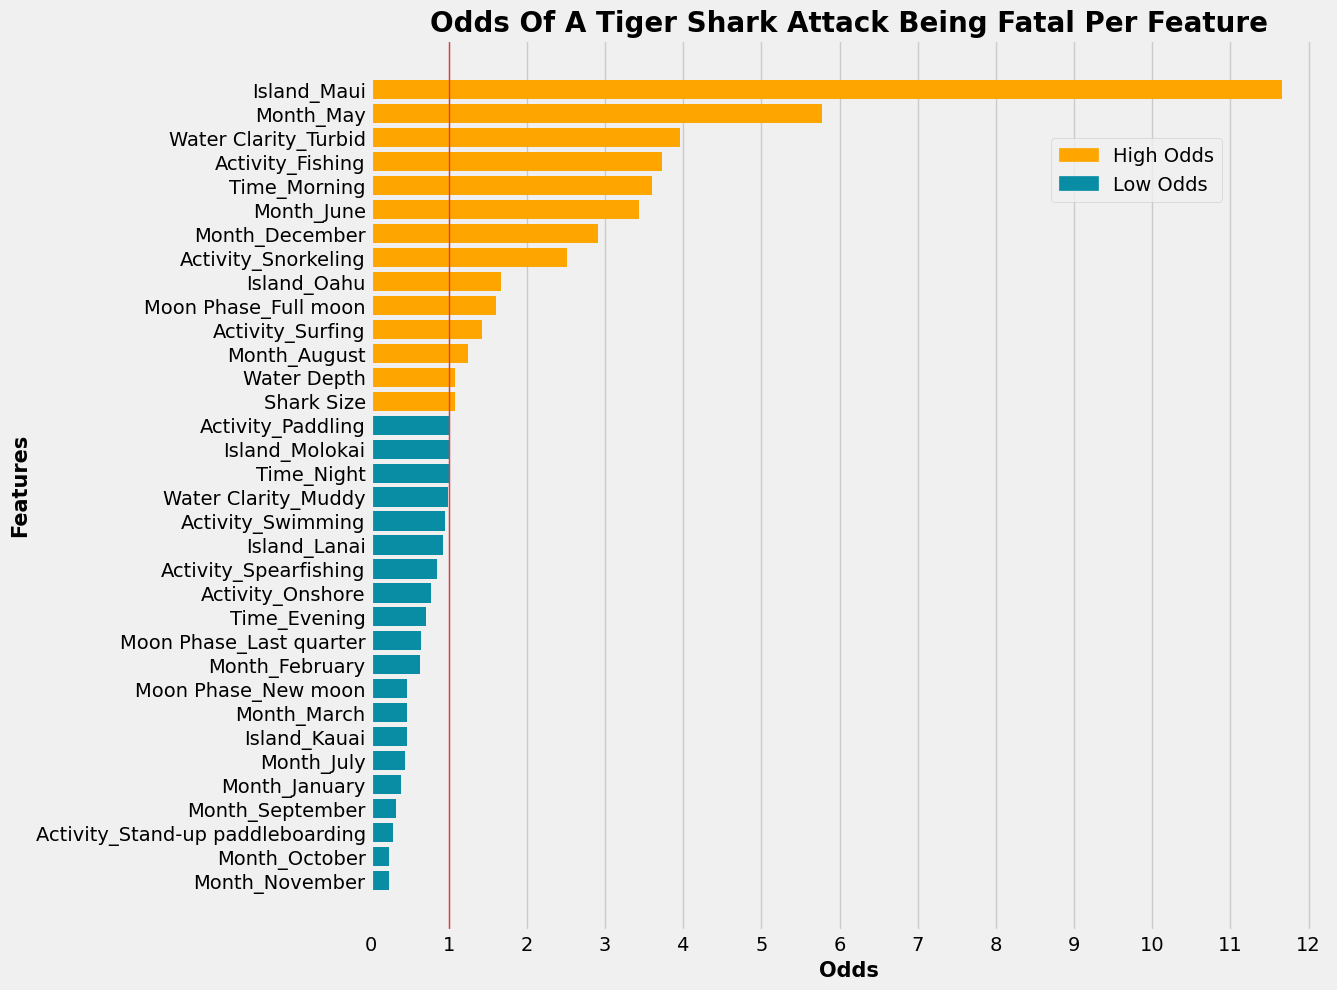

In [146]:
# Importing patches from matplotlib for custom legend in graph
import matplotlib.patches as mpatches 

# Figure size for graph
plt.figure(figsize=(11, 11))

# Graph style
plt.style.use('fivethirtyeight')

# Coefficients in terms of log-odds from model_3
coef = model_3.coef_[0]

# y-coordinate for graph
y = np.exp(coef)

# Coverting coef and y into series and sorting values
coef_series = pd.Series(data=y, index=model_3.feature_names_in_)
sorted_coef_series = s.sort_values(ascending=True)

# Colors based on a condition for bars, yellow and blue respectively
colors = ['#ffa500' if value > 1 else '#088da5' for value in sorted_coef_series.values]

# Barh graph using the coefficients in terms of odds
plt.barh(sorted_coef_series.index, sorted_coef_series.values, color=colors)

# Creating legend with color box 
blue_patch = mpatches.Patch(color='#088da5', label='Low Odds')
yellow_patch = mpatches.Patch(color='#ffa500', label='High Odds')
plt.legend(handles=[yellow_patch, blue_patch], bbox_to_anchor=(0.9, 0.9))

# Add a vertical line at x = 1 for odds threshold
plt.axvline(1, color='#ed3833', linewidth=1)

# Removes y-axis grid lines
plt.grid(axis='y', visible=False)

# x-axis tick labels
plt.xticks(range(0, 13, 1))

# Title and axis labels
plt.title('Odds Of A Tiger Shark Attack Being Fatal Per Feature', size=20, weight='bold')
plt.xlabel('Odds', size=15, weight='bold')
plt.ylabel('Features', size=15, weight='bold')

Some of the notable higher odds of a Tiger shark attack being fatal are about:

* 1000% higher on the island of Maui compared to other islands.
* 500% higher in the month of May than any other month.
* 250% higher in the month of June than any other month.
* 200% higher in the month of December than any other month.
* 250% higher in the morning than any other time of day.
* 300% higher when the water clarity is turbid than any other water clarity.
* 250% higher when fishing on a board in open water than any other activity.
* 100% higher around a full moon than any other moon phase.

# Conclusion

In this project we formulated a logistic regression model on data about Tiger shark attacks in Hawaii to see if we could predict whether an attack from a Tiger shark would be fatal or not based on certain conditions. The model was trained on a balanced version of our original data by upsampling from the minority class. We then tuned the model and scored it on unseen data. The final model received a generalized accuracy score of `95.53%`. Sensitivity is at `100%`, predicting all true positives correctly. Precision is at a `91.85%`, falsely predicting a small amount of negative classes as positives. In the case of predicting fatal Tiger shark attacks using this model, a few false positives can leave you safer than sorry!

While the likelihood of a tiger shark attack is low, this model can assist in determining when conditions are least conducive to a fatal encounter.